# Import Library

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from joblib import dump, load
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from extract_func.Extract_PTE_function import make_interpolator

2023-05-03 15:58:11.533975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Show distribution of GNSS stations

In [2]:
US_gnss = pd.read_csv('../GNSS_US/US/GPS_stations/product2/gnssStationList_overbbox.csv')
Global_gnss = pd.read_csv('../GNSS/Global_dat/GNSS/gnssStationList_overbbox.csv')

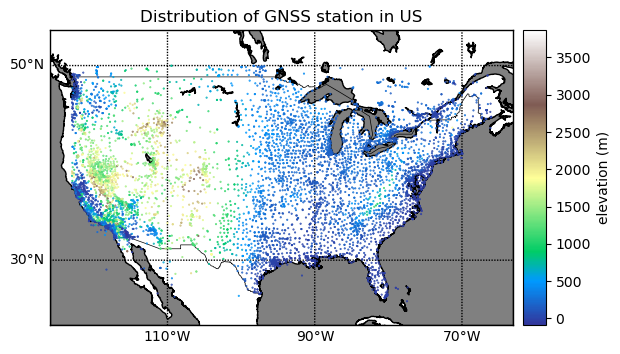

In [3]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = US_gnss['Lat']
lon = US_gnss['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,20)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', s=1, zorder=5, c=US_gnss['Hgt_m'], cmap='terrain')
# plt.savefig('../../../AGU2022_plot/US_GNSS_dist.png', dpi=600)
m.colorbar(label='elevation (m)')
plt.title('Distribution of GNSS station in US')
plt.show()

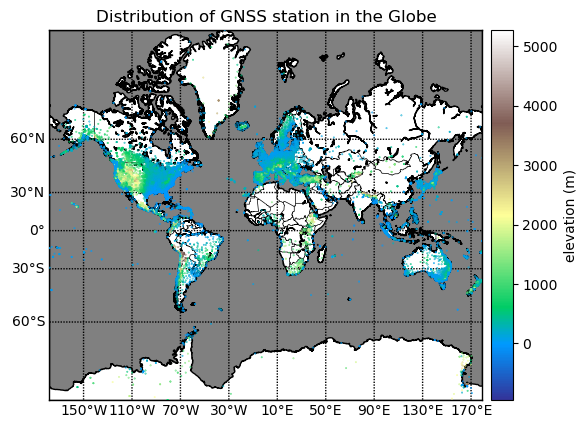

In [4]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = Global_gnss['Lat']
lon = Global_gnss['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 0 # buffer to add to the range
lat_min = -80
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,40)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=Global_gnss['Hgt_m'], cmap='terrain',s=0.5, zorder=5)
# plt.savefig('../../../AGU2022_plot/US_GNSS_dist.png', dpi=600)
m.colorbar(label='elevation (m)')
plt.title('Distribution of GNSS station in the Globe')
plt.show()

# Correlation of ZTD and altitude

In [5]:
new_test = pd.read_csv('../GNSS/Global_dat/Full_Global_data/test_global_PTE_vert_fixed_hgtlvs_with_pred.csv')

In [6]:
new_test

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  \
0          1082502  D143  2021-01-10  2.2784     0.0470             2.2314   
1          1082503  OHLC  2021-01-10  2.3306     0.0446             2.2860   
2          1082504  TGRI  2021-01-10  2.2803     0.1029             2.1774   
3          1082505  X059  2021-01-10  2.3109     0.0165             2.2944   
4          1082506  IABL  2021-01-10  2.3108     0.0415             2.2693   
...            ...   ...         ...     ...        ...                ...   
457475     1539977  J782  2022-10-17  2.3381     0.1235             2.2146   
457476     1539978  P080  2022-10-17  1.8765     0.0447             1.8318   
457477     1539979  GACE  2022-10-17  2.3348     0.1518             2.1830   
457478     1539980  TGBS  2022-10-17  2.4852     0.1728             2.3124   
457479     1539981  P397  2022-10-17  2.2313     0.0741             2.1572   

        times  sigZTD      Lat       Lon  ...      e_45      e_46      e_47  \
0           0  0.0026  50.7323   12.5203  ...  0.032060  0.027417  0.023558   
1           0  0.0026  41.7212  -83.5263  ...  0.033288  0.029017  0.025795   
2           0  0.0034 -38.9771  175.8585  ...  0.029205  0.023876  0.021358   
3           0  0.0037  34.8012  138.0731  ...  0.033044  0.028310  0.024358   
4           0  0.0027  40.7408  -92.4309  ...  0.033409  0.028564  0.024460   
...       ...     ...      ...       ...  ...       ...       ...       ...   
457475      0  0.0025  44.3651  142.2645  ...  0.039768  0.032811  0.027906   
457476      0  0.0023  39.1194 -114.2772  ...  0.043733  0.036500  0.029793   
457477      0  0.0027  34.5114  -83.5237  ...  0.041998  0.034082  0.028726   
457478      0  0.0026  53.5769    6.6614  ...  0.039257  0.032777  0.027944   
457479      0  0.0023  46.4216 -123.7992  ...  0.041095  0.034114  0.028796   

            e_48      e_49      e_50      e_51  rf_Model_prediction  \
0       0.012157  0.006304  0.002424 -0.001055             2.267286   
1       0.012191  0.006212  0.002963  0.001417             2.342560   
2       0.012107  0.006411  0.003133  0.000815             2.287976   
3       0.012449  0.006126  0.003159  0.000666             2.322539   
4       0.011663  0.006376  0.003002  0.001422             2.317579   
...          ...       ...       ...       ...                  ...   
457475  0.012748  0.006563  0.003218  0.001391             2.323491   
457476  0.012942  0.006629  0.003261  0.001381             1.872529   
457477  0.012957  0.006263  0.002832  0.001022             2.354305   
457478  0.013185  0.006485  0.003055  0.001409             2.459804   
457479  0.013295  0.006877  0.003150  0.001446             2.233227   

        nn_model_prediction    WM_ZTD  
0                  2.267729  2.273620  
1                  2.345321  2.355923  
2                  2.286639  2.301905  
3                  2.317984  2.325357  
4                  2.310547  2.335052  
...                     ...       ...  
457475             2.321986  2.341024  
457476             1.871174  1.891669  
457477             2.348444  2.367171  
457478             2.467183  2.470469  
457479             2.243631  2.254035  

[457480 rows x 167 columns]

In [7]:
one_date = new_test[new_test['Date']=='2021-01-25'].reset_index(drop=True)

In [8]:
one_date.head()

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  times  \
0     1093335  D143  2021-01-25  2.2190     0.0394             2.1796      0   
1     1093336  OHLC  2021-01-25  2.3494     0.0780             2.2714      0   
2     1093337  TGRI  2021-01-25  2.3028     0.1302             2.1726      0   
3     1093338  X059  2021-01-25  2.3729     0.0605             2.3124      0   
4     1093339  IABL  2021-01-25  2.3205     0.0737             2.2468      0   

   sigZTD      Lat       Lon  ...      e_45      e_46      e_47      e_48  \
0  0.0026  50.7323   12.5203  ...  0.032692  0.028593  0.025330  0.012363   
1  0.0022  41.7212  -83.5263  ...  0.035130  0.030069  0.025780  0.011815   
2  0.0036 -38.9771  175.8585  ...  0.036903  0.030921  0.025110  0.012206   
3  0.0040  34.8012  138.0731  ...  0.035415  0.030229  0.025806  0.011852   
4  0.0026  40.7408  -92.4309  ...  0.034432  0.030245  0.025901  0.011812   

       e_49      e_50      e_51  rf_Model_prediction  nn_model_prediction  \
0  0.006484  0.002100 -0.002192             2.210145             2.213663   
1  0.006050  0.003062  0.001452             2.344165             2.342039   
2  0.006324  0.003040  0.000612             2.306302             2.306161   
3  0.006091  0.003007  0.001318             2.402842             2.397911   
4  0.005830  0.003099  0.001485             2.311533             2.316961   

     WM_ZTD  
0  2.223226  
1  2.372200  
2  2.316832  
3  2.403546  
4  2.343931  

[5 rows x 167 columns]

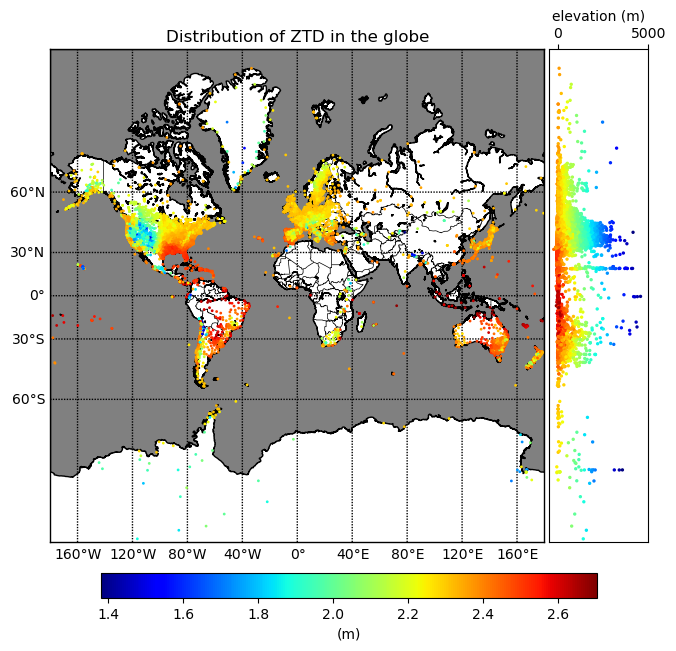

In [9]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = one_date['Lat']
lon = one_date['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 0 # buffer to add to the range
# lat_min = min(lat) - margin
# lat_max = max(lat) + margin
# lon_min = min(lon) - margin
# lon_max = max(lon) + margin
fig, axes = plt.subplots(1,1, figsize=(8,8))
# create map using BASEMAP
m = Basemap(llcrnrlon=-180,
            llcrnrlat=-85,
            urcrnrlon=180,
            urcrnrlat=85,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000,
            ax=axes
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(0.,360.,40)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, c=one_date['ZTD'], cmap='jet', s=1, zorder=3)
divider = make_axes_locatable(axes)
y_hist = divider.append_axes('right', pad='1%', size='20%', sharey=axes)
y_hist.scatter(one_date['Hgt_m'], lats, c=one_date['ZTD'], cmap='jet', s=2)
y_hist.set_xlabel('elevation (m)')
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.set_xticks([0, 5000])
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
fig.colorbar(a,ax=axes, label='(m)', pad=0.05, shrink=0.8, orientation='horizontal')
axes.set_title('Distribution of ZTD in the globe')
plt.savefig('Plots/Dist_ZTD_glob.png', dpi=600)
plt.show()

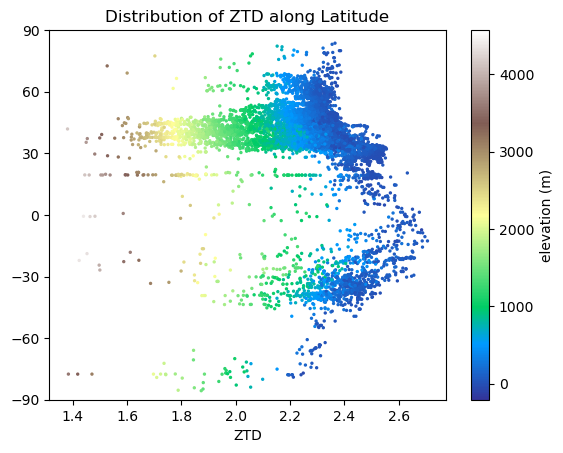

In [10]:
plt.scatter(one_date['ZTD'], one_date['Lat'],c=one_date['Hgt_m'], cmap='terrain', s=2)
plt.xlabel('ZTD')
plt.colorbar(label='elevation (m)')
plt.ylim(-90,90)
plt.yticks(np.arange(-90, 91, 30))
plt.title('Distribution of ZTD along Latitude')
plt.savefig('Plots/Dist_ZTD_Lat.png', dpi=600)
plt.show()

# Model Performance for CONUS Data

In [129]:
# Importing the libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read in data
dat_US = pd.read_csv('../GNSS_US/US/PTE_vert_fixed_hgtlvs.csv')
dat_US = dat_US.dropna()

train_US = dat_US[dat_US['Date'] < '2021-01-01']
test_US = dat_US[dat_US['Date'] >= '2021-01-01']

x_train = train_US.iloc[:, train_US.columns.str.startswith(('Lat', 'Hgt_m','P_', 'T_', 'e_'))]
x_test = test_US.iloc[:, test_US.columns.str.startswith(('Lat', 'Hgt_m','P_', 'T_', 'e_'))]
y_train = train_US[['ZTD']]
y_test = test_US[['ZTD']]


KeyboardInterrupt



In [ ]:
test_US.head()

In [ ]:
# Load in the model
CONUS_rf_model = load('Model/US_PTE_fixed_hgtlvs_RF.joblib')
import tensorflow as tf
CONUS_nn_model = tf.keras.models.load_model('Model/US_PTE_fixed_hgtlvs_model/')
CONUS_scaler_x = load('Scaler/US_noGOES_MinMax_155_scaler_x.bin')

In [ ]:
CONUS_rf_predict = CONUS_rf_model.predict(x_test).reshape(-1,1)
CONUS_nn_predict = CONUS_nn_model.predict(CONUS_scaler_x.transform(x_test))
CONUS_true = y_test.values

In [ ]:
np.std(CONUS_rf_predict),np.std(CONUS_true)

In [ ]:
plt.hist(CONUS_rf_predict-CONUS_true, bins=450)
plt.hist(CONUS_nn_predict-CONUS_true, bins=450)
plt.hist(test_US.WM_ZTD.values.reshape(-1,1)-CONUS_true, bins=450)
plt.xlim(-0.1, 0.1)
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
print("RF model")
predict = CONUS_rf_predict
true = CONUS_true
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))

# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict))
print('RMSE: %.5f' % rmse)

errors = predict - true
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

RF model
Mean squared error: 0.0003640105
Mean: 0.00101
R2: 0.98986
RMSE: 0.01908
MAE: 0.01474


In [29]:
from sklearn.metrics import mean_squared_error, r2_score
print("NN model")
predict = CONUS_nn_predict
true = CONUS_true
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))

# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict))
print('RMSE: %.5f' % rmse)

errors = predict - true
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

NN model
Mean squared error: 0.0000764411
Mean: -0.00144
R2: 0.99787
RMSE: 0.00874
MAE: 0.00584


In [30]:
from sklearn.metrics import mean_squared_error, r2_score
print("WM model")
predict = test_US.WM_ZTD.values.reshape(-1,1)-0.01625
true = CONUS_true
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))

# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict))
print('RMSE: %.5f' % rmse)

errors = predict - true
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

WM model
Mean squared error: 0.0000957495
Mean: 0.00000
R2: 0.99733
RMSE: 0.00979
MAE: 0.00668


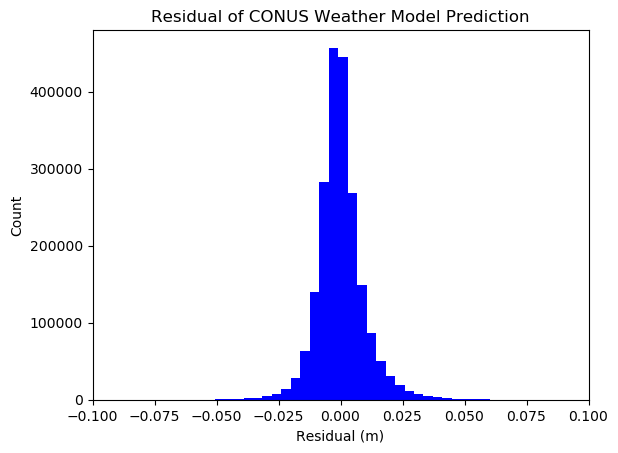

In [31]:
plt.hist(predict-true, bins=450, color='blue')
plt.title('Residual of CONUS Weather Model Prediction')
plt.xlabel('Residual (m)')
plt.ylabel('Count')
plt.xlim(-0.1, 0.1)
# plt.text(-0.08, 150000, 'RMSE: {:.5f} m\n MAE: {:.5f} m \n MEAN: {:.5f} m'.format(rmse, MAE, np.mean(rf_predict-true) ), fontsize = 8, 
#          bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

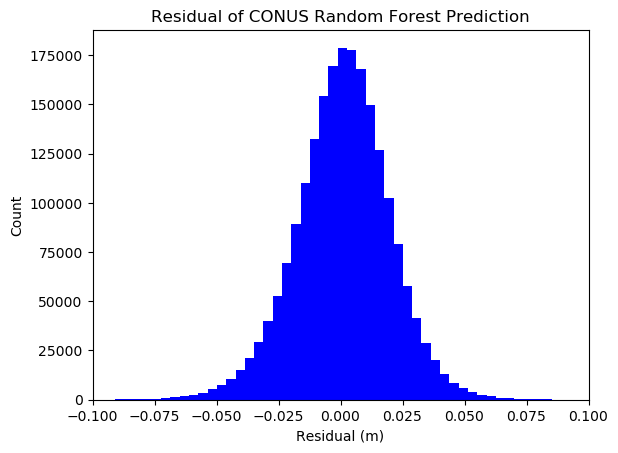

In [32]:
plt.hist(CONUS_rf_predict-CONUS_true, bins=450, color='blue')
plt.title('Residual of CONUS Random Forest Prediction')
plt.xlabel('Residual (m)')
plt.ylabel('Count')
plt.xlim(-0.1, 0.1)
# plt.text(-0.08, 150000, 'RMSE: {:.5f} m\n MAE: {:.5f} m \n MEAN: {:.5f} m'.format(rmse, MAE, np.mean(rf_predict-true) ), fontsize = 8, 
#          bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

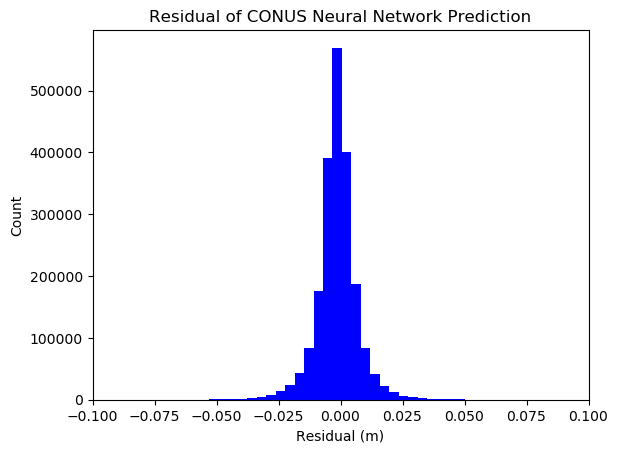

In [33]:
plt.hist(CONUS_nn_predict-CONUS_true, bins=450, color='blue')
plt.title('Residual of CONUS Neural Network Prediction')
plt.xlabel('Residual (m)')
plt.ylabel('Count')
plt.xlim(-0.1, 0.1)
# plt.text(-0.09, 400000, 'RMSE: {:.5f} m\n MAE: {:.5f} m \n MEAN: {:.5f} m'.format(0.00972, 0.00678, 0.00039 ), fontsize = 8, 
#          bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

In [34]:
test_US['nn_model_prediction'] = CONUS_nn_predict
test_US['rf_model_prediction'] = CONUS_rf_predict

In [35]:
test_US.head()

ID        Date  DOY     ZTD  wet_delay  hydrostatic_delay  times  sigZTD  \
0  OHLC  2021-01-01    1  2.3294     0.0413             2.2881  39600  0.0017   
1  IABL  2021-01-01    1  2.3344     0.0885             2.2459  39600  0.0017   
2  PSU3  2021-01-01    1  2.2815     0.0273             2.2542  39600  0.0017   
3  NEGO  2021-01-01    1  2.1586     0.0475             2.1111  39600  0.0018   
4  BCKW  2021-01-01    1  2.3241     0.1182             2.2059  39600  0.0020   

       Lat       Lon  ...      e_45      e_46      e_47      e_48      e_49  \
0  41.7212  -83.5263  ...  0.037172  0.031665  0.026855  0.012074  0.005457   
1  40.7408  -92.4309  ...  0.037242  0.031752  0.026955  0.012177  0.005506   
2  40.8069  -77.8498  ...  0.037259  0.031738  0.026932  0.012123  0.005934   
3  40.9201 -100.1659  ...  0.036228  0.031519  0.026862  0.012212  0.005502   
4  49.8848 -119.4954  ...  0.036592  0.031350  0.026782  0.012314  0.005808   

       e_50      e_51  nn_model_prediction  rf_model_prediction    WM_ZTD  
0  0.002980 -0.000133             2.325704             2.327218  2.345241  
1  0.002845 -0.000139             2.324994             2.322520  2.343962  
2  0.002881  0.000521             2.279577             2.281915  2.298813  
3  0.002824 -0.000043             2.154335             2.157977  2.167268  
4  0.002909  0.001319             2.312625             2.311394  2.327324  

[5 rows x 167 columns]

Calculate with regular grid interpolator to derived hydro and wet delay at each GNSS station or pixel of interest

In [29]:
import glob
import xarray as xr
weather_file_path = '../GNSS_US/US/weather_model/weather_files/'
test_US['WM_ZTD'] = 0
dates_ = set(test_US.Date.values)
for i, date in enumerate(dates_):
    print(date)
    df = test_US[test_US['Date']==date]
    loc = np.hstack((df.Lon.values.reshape(-1,1), df.Lat.values.reshape(-1,1), df.Hgt_m.values.reshape(-1,1)))
    with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T11_00_00*[A-Z].nc'.format(date=date.replace('-', '_'))))) as wm:
        hydro_total_1_interp = make_interpolator(wm, 'hydro_total')
        wet_total_1_interp = make_interpolator(wm, 'wet_total')
  
    hydro1 = hydro_total_1_interp(loc)
    wet1 = wet_total_1_interp(loc)
    td1 = hydro1 + wet1
    test_US.loc[test_US.groupby('Date').get_group(date).index,'WM_ZTD'] = td1
    

/tmp/ipykernel_18838/1283248378.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_US['WM_ZTD'] = 0


2021-09-22
2021-01-02
2022-02-26
2021-08-09
2021-03-09
2022-04-15
2021-05-26
2021-11-02
2021-03-05
2022-01-13
2021-06-16
2022-01-08
2021-05-05
2022-02-04
2021-06-04
2021-11-01
2021-04-04
2022-01-07
2021-10-13
2022-01-05
2022-02-07
2021-08-20
2021-11-17
2022-02-21
2021-12-04
2021-05-22
2021-11-12
2021-03-01
2022-03-11
2021-01-06
2021-11-09
2021-10-15
2022-02-17
2021-03-26
2022-04-19
2021-06-09
2021-03-14
2021-05-03
2021-02-28
2021-10-27
2022-03-16
2022-04-28
2022-02-03
2021-04-17
2021-12-20
2021-11-03
2021-09-12
2021-04-20
2022-02-10
2021-03-27
2021-12-30
2021-05-04
2021-09-15
2021-04-01
2022-03-01
2021-06-25
2021-01-28
2021-11-11
2022-02-05
2022-02-28
2021-05-12
2021-05-06
2021-01-24
2021-02-09
2022-02-18
2022-01-28
2021-06-24
2021-07-25
2022-04-16
2021-06-15
2021-08-13
2021-09-10
2021-10-21
2021-07-19
2022-02-16
2021-06-11
2021-08-16
2021-08-24
2021-04-16
2021-02-08
2021-10-08
2022-01-22
2021-09-20
2021-06-05
2021-10-19
2021-08-05
2022-01-27
2021-11-16
2021-09-01
2022-01-24
2021-11-28

In [31]:
test_US.to_csv('../GNSS_US/test_CONUS_PTE_vert_fixed_hgtlvs_with_pred.csv',index=False)

In [130]:
test_US = pd.read_csv("../GNSS_US/test_CONUS_PTE_vert_fixed_hgtlvs_with_pred.csv")

In [131]:
test_US.head()

ID        Date  DOY     ZTD  wet_delay  hydrostatic_delay  times  sigZTD  \
0  OHLC  2021-01-01    1  2.3294     0.0413             2.2881  39600  0.0017   
1  IABL  2021-01-01    1  2.3344     0.0885             2.2459  39600  0.0017   
2  PSU3  2021-01-01    1  2.2815     0.0273             2.2542  39600  0.0017   
3  NEGO  2021-01-01    1  2.1586     0.0475             2.1111  39600  0.0018   
4  BCKW  2021-01-01    1  2.3241     0.1182             2.2059  39600  0.0020   

       Lat       Lon  ...      e_45      e_46      e_47      e_48      e_49  \
0  41.7212  -83.5263  ...  0.037172  0.031665  0.026855  0.012074  0.005457   
1  40.7408  -92.4309  ...  0.037242  0.031752  0.026955  0.012177  0.005506   
2  40.8069  -77.8498  ...  0.037259  0.031738  0.026932  0.012123  0.005934   
3  40.9201 -100.1659  ...  0.036228  0.031519  0.026862  0.012212  0.005502   
4  49.8848 -119.4954  ...  0.036592  0.031350  0.026782  0.012314  0.005808   

       e_50      e_51  nn_model_prediction  rf_model_prediction    WM_ZTD  
0  0.002980 -0.000133             2.325704             2.327218  2.345241  
1  0.002845 -0.000139             2.324994             2.322520  2.343962  
2  0.002881  0.000521             2.279577             2.281915  2.298813  
3  0.002824 -0.000043             2.154335             2.157977  2.167268  
4  0.002909  0.001319             2.312625             2.311394  2.327324  

[5 rows x 167 columns]

In [132]:
error_by_station = test_US.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_model_prediction', 'WM_ZTD']]

/tmp/ipykernel_57311/3566216616.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_station = test_US.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_model_prediction', 'WM_ZTD']]


In [133]:
error_by_station

Lat       Lon    Hgt_m       ZTD  nn_model_prediction  \
ID                                                                
14PT  45.4001  -75.9194   45.265  2.339500             2.342155   
14ST  45.4001  -75.9194   45.263  2.366500             2.361472   
14T1  45.4001  -75.9194   45.260  2.356767             2.359048   
1LSU  30.4074  -91.1803   -6.487  2.488099             2.479180   
1NSU  31.7508  -93.0976   28.071  2.468683             2.465092   
...       ...       ...      ...       ...                  ...   
ZOA2  37.5430 -122.0159   -3.528  2.394122             2.392324   
ZOB1  41.2972  -82.2064  223.618  2.352454             2.352125   
ZSE1  47.2870 -122.1884   82.065  2.387858             2.386398   
ZTL4  33.3797  -84.2967  261.134  2.380892             2.380316   
ZUMB  44.2907  -92.6813  295.980  2.314712             2.311303   

      rf_model_prediction    WM_ZTD  
ID                                   
14PT             2.347051  2.354981  
14ST             2.347051  2.377381  
14T1             2.366435  2.374479  
1LSU             2.478497  2.502542  
1NSU             2.469558  2.486606  
...                   ...       ...  
ZOA2             2.394479  2.410599  
ZOB1             2.355400  2.372439  
ZSE1             2.389492  2.401720  
ZTL4             2.376294  2.402296  
ZUMB             2.316300  2.329688  

[5192 rows x 7 columns]

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [19]:
error_by_station['nn_Avg_error'] = (test_US.nn_model_prediction-test_US.ZTD).groupby(test_US['ID']).mean()
error_by_station['nn_RMSE'] = test_US.groupby('ID').apply(rmse)['rmse']
error_by_station['rf_Avg_error'] = (test_US.rf_model_prediction-test_US.ZTD).groupby(test_US['ID']).mean()
error_by_station['rf_RMSE'] = test_US.groupby('ID').apply(rmse_)['rmse']
error_by_station['wm_Avg_error'] = (test_US.WM_ZTD-test_US.ZTD).groupby(test_US['ID']).mean()
error_by_station['wm_RMSE'] = test_US.groupby('ID').apply(rmse__)['rmse']

In [20]:
error_by_station.head()

Lat      Lon   Hgt_m       ZTD  nn_model_prediction  \
ID                                                              
14PT  45.4001 -75.9194  45.265  2.339500             2.342155   
14ST  45.4001 -75.9194  45.263  2.366500             2.361472   
14T1  45.4001 -75.9194  45.260  2.356767             2.359048   
1LSU  30.4074 -91.1803  -6.487  2.488099             2.479180   
1NSU  31.7508 -93.0976  28.071  2.468683             2.465092   

      rf_model_prediction    WM_ZTD  nn_Avg_error   nn_RMSE  rf_Avg_error  \
ID                                                                          
14PT             2.347051  2.354981      0.002655  0.002655      0.007551   
14ST             2.347051  2.377381     -0.005028  0.005028     -0.019449   
14T1             2.366435  2.374479      0.002281  0.003324      0.009668   
1LSU             2.478497  2.502542     -0.008920  0.013960     -0.009602   
1NSU             2.469558  2.486606     -0.003591  0.012062      0.000875   

       rf_RMSE  wm_Avg_error   wm_RMSE  
ID                                      
14PT  0.007551      0.015481  0.015481  
14ST  0.019449      0.010881  0.010881  
14T1  0.024815      0.017712  0.017880  
1LSU  0.022993      0.014443  0.018576  
1NSU  0.021209      0.017923  0.021864

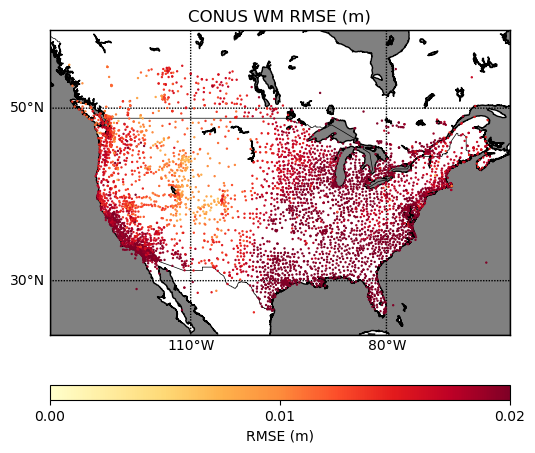

In [446]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,30)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=error_by_station['wm_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
cbar = m.colorbar(label='RMSE (m)', location='bottom', pad=0.5)
cbar.set_ticks([0, 0.01, 0.02])
plt.title('CONUS WM RMSE (m)')
plt.savefig('Plots/CONUS_WM_RMSE.png', dpi=250)
plt.show()

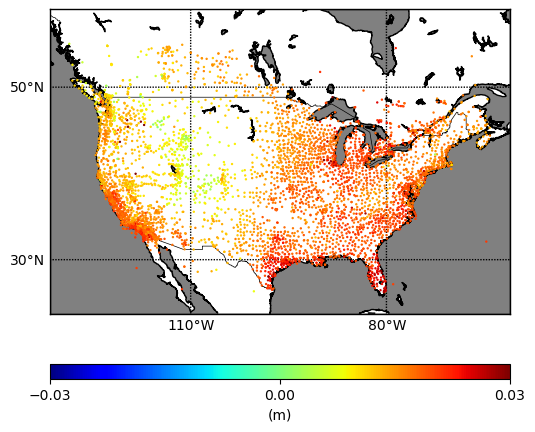

In [456]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,30)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=np.abs(error_by_station['wm_Avg_error']), cmap='jet', s=2, zorder=5, vmin=-0.03, vmax=0.03)
cbar = m.colorbar(label='(m)', pad= 0.5, location='bottom')
cbar.set_ticks([-0.03, 0, 0.03])
# plt.title('CONUS WM RMSE (m)')
# plt.savefig('Plots/CONUS_WM_avgError.png', dpi=250)
plt.show()

<Figure size 640x480 with 0 Axes>

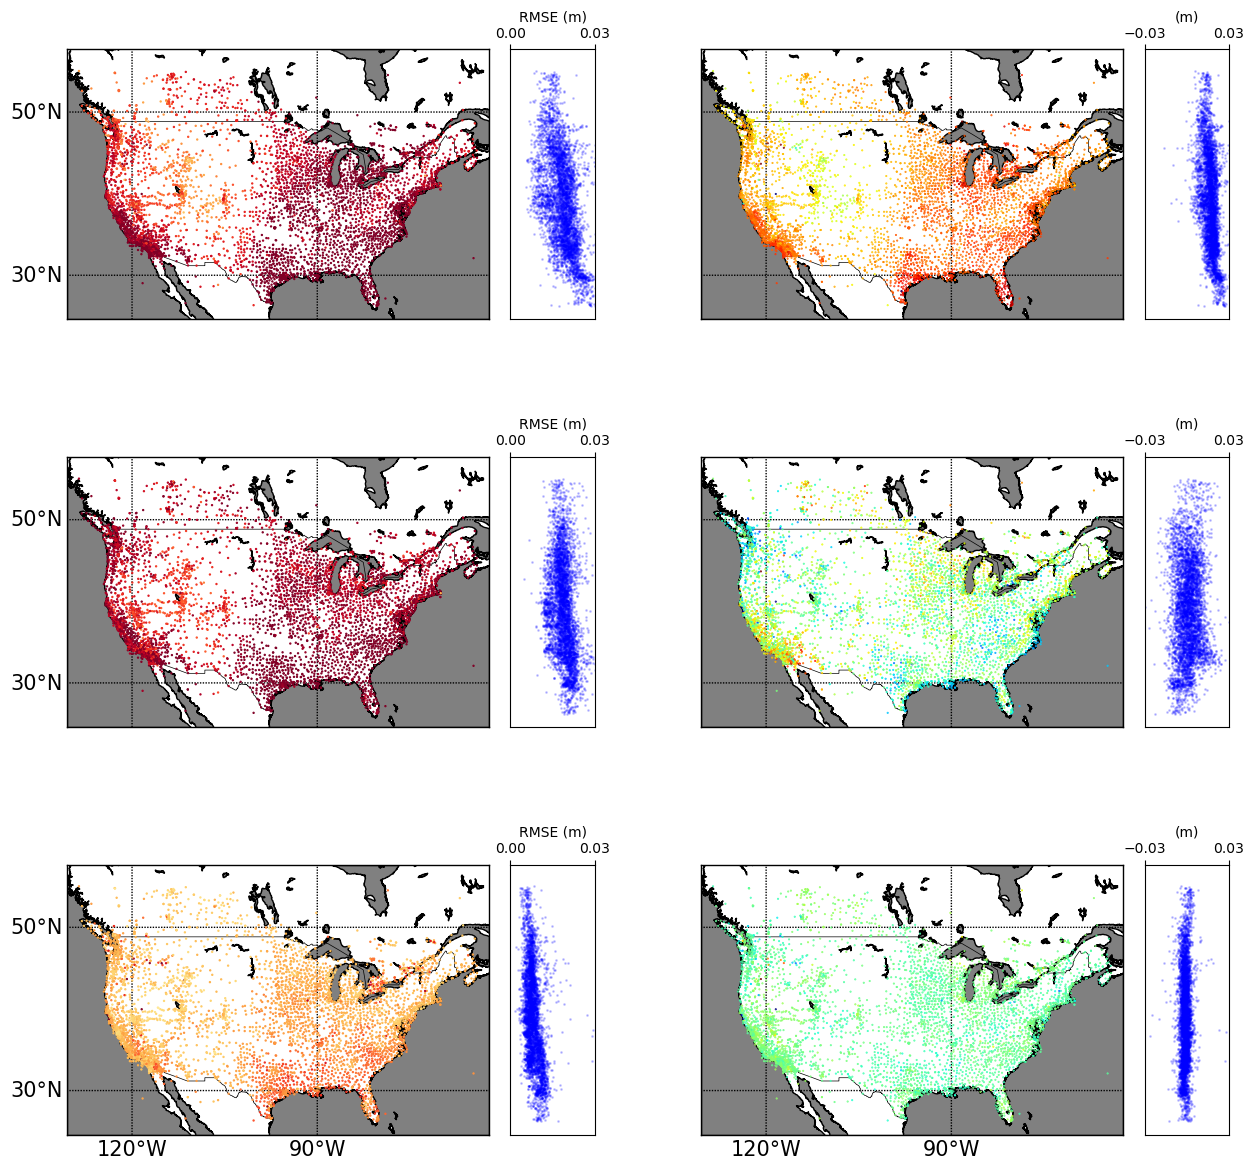

In [450]:
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 2 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin
plt.clf()
fig, axes = plt.subplots(3,2, figsize=(15,15))

# axes[0,0].set_title('WM_RMSE')
m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[0,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=15)
meridians = np.arange(0,360.,30)
m.drawmeridians(meridians,labels=[True,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['wm_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
divider = make_axes_locatable(axes[0,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[0,0])
y_hist.scatter(error_by_station['wm_RMSE'], lats, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.03)
y_hist.set_xticks([0, 0.03])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 


m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[1,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[True,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['rf_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
divider = make_axes_locatable(axes[1,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[1,0])
y_hist.scatter(error_by_station['rf_RMSE'], lats, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.03)
y_hist.set_xticks([0, 0.03])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[2,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['nn_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
divider = make_axes_locatable(axes[2,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[2,0])
y_hist.scatter(error_by_station['nn_RMSE'], lats, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.03)
y_hist.set_xticks([0, 0.03])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[0,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[False,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['wm_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.03, vmax=0.03)
divider = make_axes_locatable(axes[0,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[0,1])
y_hist.scatter(error_by_station['WM_ZTD'] - error_by_station['ZTD'], lats, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.03, 0.03)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[1,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[False,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['rf_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.03, vmax=0.03)
divider = make_axes_locatable(axes[1,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[1,1])
y_hist.scatter(error_by_station['rf_model_prediction'] - error_by_station['ZTD'], lats, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.03, 0.03)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[2,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,True], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['nn_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.03, vmax=0.03)
divider = make_axes_locatable(axes[2,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[2,1])
y_hist.scatter(error_by_station['nn_model_prediction'] - error_by_station['ZTD'], lats, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.03, 0.03)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
fig.savefig('Plots/CONUS_RMSE_avgError.png', dpi=350)
plt.show()

## Residual with time

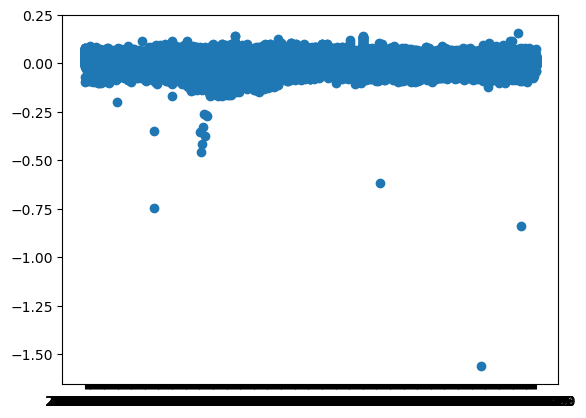

In [136]:
plt.scatter(test_US.Date, test_US.WM_ZTD- test_US.ZTD)
plt.show()

# Model Performance for Global Data

In [2]:
new_test = pd.read_csv('../GNSS/Global_dat/Full_Global_data/test_global_PTE_vert_fixed_hgtlvs_with_pred.csv')

In [7]:
from joblib import dump, load
import tensorflow as tf
rf_model = load('Model/Global_PTE_fixed_hgtlvs_RF.joblib') # This take a very long time to load because of it's 16 GB
nn_model = tf.keras.models.load_model('Model/global_PTE_fixed_hgtlvs_02_20_model')
scaler_x = load('Scaler/global_MinMax_scaler_x.bin')

2023-04-16 00:42:26.328860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
new_test.head()

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  times  \
0     1082502  D143  2021-01-10  2.2784     0.0470             2.2314      0   
1     1082503  OHLC  2021-01-10  2.3306     0.0446             2.2860      0   
2     1082504  TGRI  2021-01-10  2.2803     0.1029             2.1774      0   
3     1082505  X059  2021-01-10  2.3109     0.0165             2.2944      0   
4     1082506  IABL  2021-01-10  2.3108     0.0415             2.2693      0   

   sigZTD      Lat       Lon  ...      e_45      e_46      e_47      e_48  \
0  0.0026  50.7323   12.5203  ...  0.032060  0.027417  0.023558  0.012157   
1  0.0026  41.7212  -83.5263  ...  0.033288  0.029017  0.025795  0.012191   
2  0.0034 -38.9771  175.8585  ...  0.029205  0.023876  0.021358  0.012107   
3  0.0037  34.8012  138.0731  ...  0.033044  0.028310  0.024358  0.012449   
4  0.0027  40.7408  -92.4309  ...  0.033409  0.028564  0.024460  0.011663   

       e_49      e_50      e_51  rf_Model_prediction  nn_model_prediction  \
0  0.006304  0.002424 -0.001055             2.267286             2.267729   
1  0.006212  0.002963  0.001417             2.342560             2.345321   
2  0.006411  0.003133  0.000815             2.287976             2.286639   
3  0.006126  0.003159  0.000666             2.322539             2.317984   
4  0.006376  0.003002  0.001422             2.317579             2.310547   

     WM_ZTD  
0  2.273620  
1  2.355923  
2  2.301905  
3  2.325357  
4  2.335052  

[5 rows x 167 columns]

In [122]:
# error_by_station = new_test.groupby('Month',as_index=False).mean()[['Month', 'Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]
error_by_station = new_test.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]
error_by_station.head()

/tmp/ipykernel_18838/2304268470.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_station = new_test.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]


Lat      Lon    Hgt_m       ZTD  nn_model_prediction  \
ID                                                               
0ABI  68.3543  18.8164  431.388  2.240380             2.236751   
0ABY  58.6589  16.1796   60.548  2.384332             2.379727   
0AKE  59.4814  18.3020   43.131  2.384377             2.380810   
0ALE  62.7805  16.0137  272.454  2.304998             2.301515   
0ALF  61.3445  16.0649  142.743  2.349534             2.345494   

      rf_Model_prediction    WM_ZTD  
ID                                   
0ABI             2.238568  2.249014  
0ABY             2.383474  2.388727  
0AKE             2.381322  2.389516  
0ALE             2.302740  2.311721  
0ALF             2.349247  2.354788

In [124]:
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_Model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [125]:
error_by_station['nn_Avg_error'] = (new_test.nn_model_prediction-new_test.ZTD).groupby(new_test['ID']).mean()
error_by_station['nn_RMSE'] = new_test.groupby('ID').apply(rmse)['rmse']
error_by_station['rf_Avg_error'] = (new_test.rf_Model_prediction-new_test.ZTD).groupby(new_test['ID']).mean()
error_by_station['rf_RMSE'] = new_test.groupby('ID').apply(rmse_)['rmse']
error_by_station['wm_Avg_error'] = (new_test.WM_ZTD-new_test.ZTD).groupby(new_test['ID']).mean()
error_by_station['wm_RMSE'] = new_test.groupby('ID').apply(rmse__)['rmse']

In [19]:
error_by_station.head()

Lat      Lon    Hgt_m       ZTD  nn_model_prediction  \
ID                                                               
0ABI  68.3543  18.8164  431.388  2.240380             2.236751   
0ABY  58.6589  16.1796   60.548  2.384332             2.379727   
0AKE  59.4814  18.3020   43.131  2.384377             2.380810   
0ALE  62.7805  16.0137  272.454  2.304998             2.301515   
0ALF  61.3445  16.0649  142.743  2.349534             2.345494   

      rf_Model_prediction    WM_ZTD  nn_Avg_error   nn_RMSE  rf_Avg_error  \
ID                                                                          
0ABI             2.238568  2.249014     -0.003628  0.007216     -0.001811   
0ABY             2.383474  2.388727     -0.004605  0.008966     -0.000858   
0AKE             2.381322  2.389516     -0.003568  0.011536     -0.003056   
0ALE             2.302740  2.311721     -0.003482  0.008105     -0.002257   
0ALF             2.349247  2.354788     -0.004040  0.006754     -0.000287   

       rf_RMSE  wm_Avg_error   wm_RMSE  
ID                                      
0ABI  0.007411      0.008635  0.010152  
0ABY  0.007675      0.004395  0.007984  
0AKE  0.010372      0.005139  0.011752  
0ALE  0.008374      0.006723  0.009896  
0ALF  0.007486      0.005254  0.007735

<Figure size 640x480 with 0 Axes>

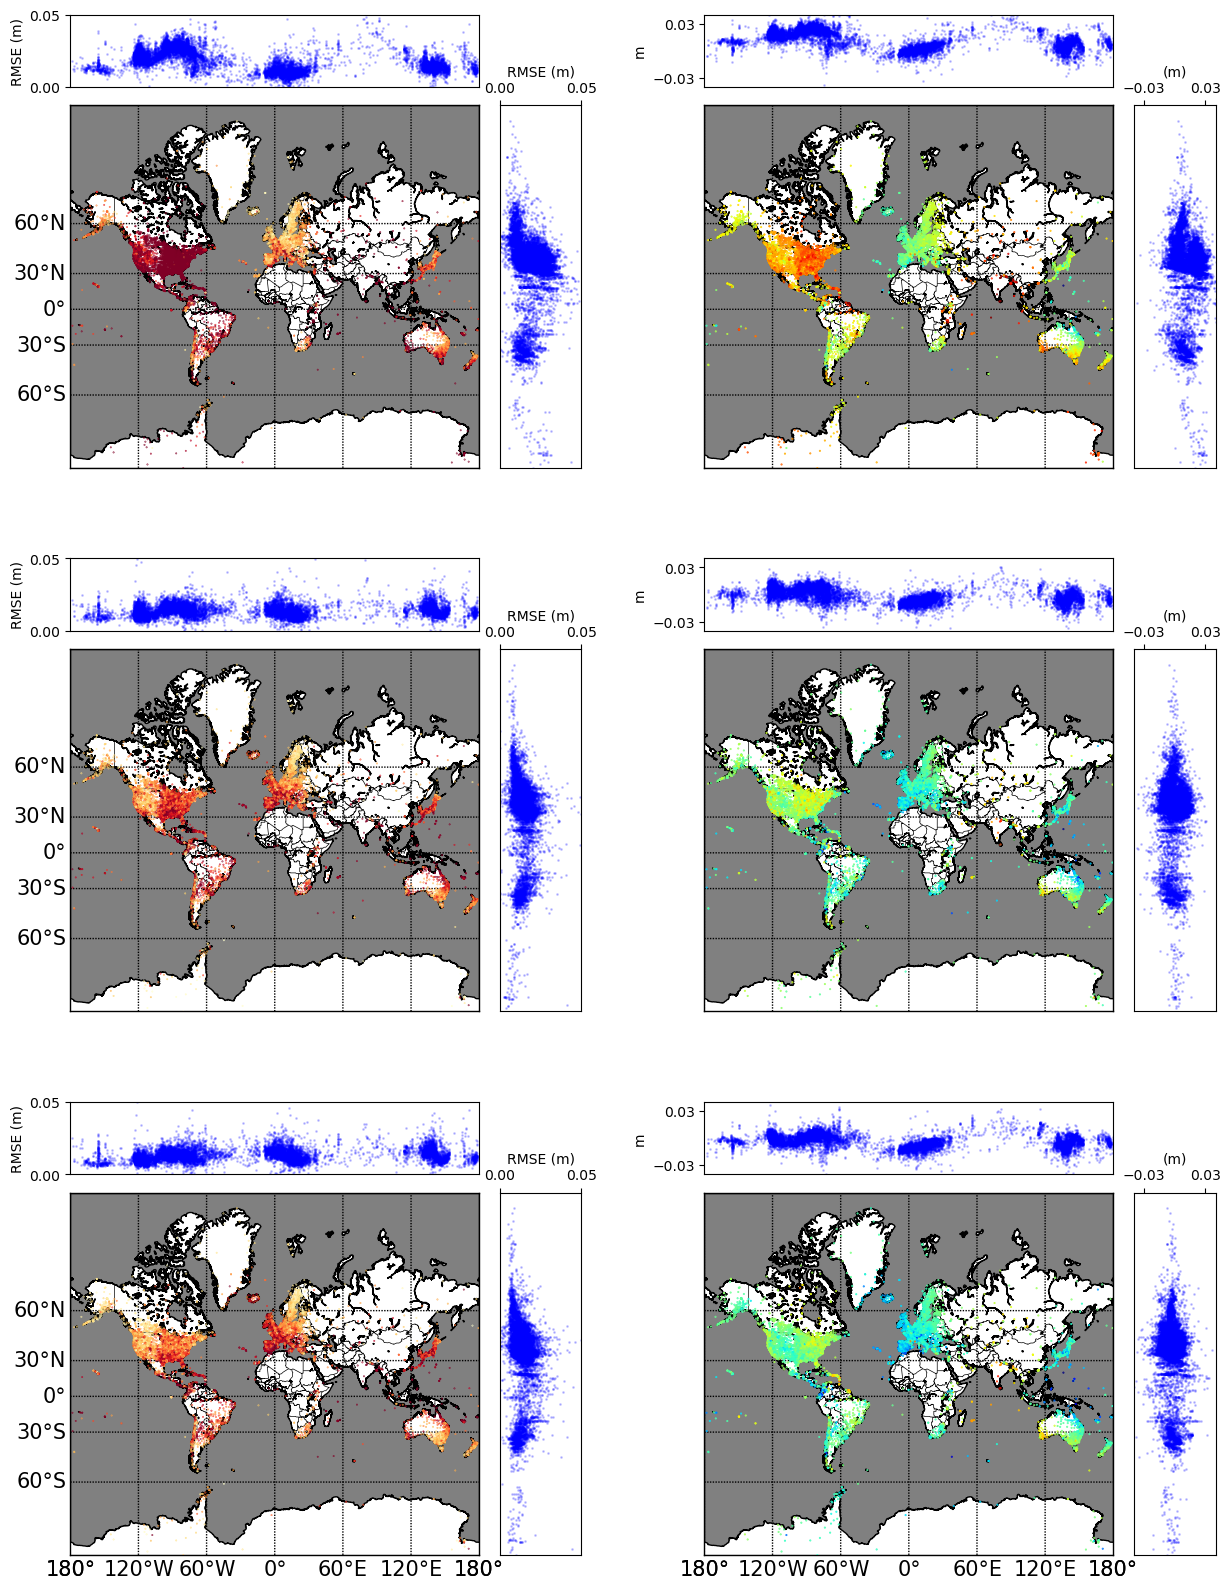

In [74]:
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 0 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin
plt.clf()
fig, axes = plt.subplots(3,2, figsize=(15,20))

# axes[0,0].set_title('WM_RMSE')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[0,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=15)
meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[True,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['wm_RMSE'], cmap='YlOrRd', s=0.5, zorder=5, vmin=0.005, vmax=0.02)
divider = make_axes_locatable(axes[0,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[0,0])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[0,0])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.wm_RMSE,stat_lat, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.05)
y_hist.set_xticks([0,0.05])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.wm_RMSE, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('RMSE (m)')
x_plot.set_ylim(0, 0.05)
x_plot.set_yticks([0,0.05])
x_plot.yaxis.set_tick_params(labelsize=10)


# axes[1,0].set_title('RF_RMSE')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[1,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[True,False,False,False], fontsize=15)
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['rf_RMSE'], cmap='YlOrRd', s=0.5, zorder=5, vmin=0.005, vmax=0.02)
divider = make_axes_locatable(axes[1,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[1,0])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[1,0])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.rf_RMSE,stat_lat, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.05)
y_hist.set_xticks([0,0.05])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.rf_RMSE, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('RMSE (m)')
x_plot.set_ylim(0, 0.05)
x_plot.set_yticks([0,0.05])
x_plot.yaxis.set_tick_params(labelsize=10)


# axes[2,0].set_title('NN_RMSE')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[2,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], fontsize=15)
# meridians = np.arange(0.,351.,50)
m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=15)
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['nn_RMSE'], cmap='YlOrRd', s=0.5, zorder=5, vmin=0.005, vmax=0.02)
divider = make_axes_locatable(axes[2,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[2,0])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[2,0])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.nn_RMSE,stat_lat, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.05)
y_hist.set_xticks([0,0.05])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.nn_RMSE, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('RMSE (m)')
x_plot.set_ylim(0, 0.05)
x_plot.set_yticks([0,0.05])
x_plot.yaxis.set_tick_params(labelsize=10)


# axes[0,1].set_title('WM_Avg_Error')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[0,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False])
# meridians = np.arange(0.,351.,50)
m.drawmeridians(meridians,labels=[False,False,False,False])
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['wm_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.04, vmax=0.04)
divider = make_axes_locatable(axes[0,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[0,1])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[0,1])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.wm_Avg_error,stat_lat, color='blue',s=1, alpha=0.2,)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.04, 0.04)
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.wm_Avg_error, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('m')
x_plot.set_ylim(-0.04, 0.04)
x_plot.set_yticks([-0.03, 0.03])
x_plot.yaxis.set_tick_params(labelsize=10)


# axes[1,1].set_title('RF_Avg_Error')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[1,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False])
# meridians = np.arange(0.,351.,50)
m.drawmeridians(meridians,labels=[False,False,False,False])
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['rf_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.04, vmax=0.04)
divider = make_axes_locatable(axes[1,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[1,1])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[1,1])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.rf_Avg_error,stat_lat, color='blue',s=1, alpha=0.2,)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.04, 0.04)
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.rf_Avg_error, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('m')
x_plot.set_ylim(-0.04, 0.04)
x_plot.set_yticks([-0.03, 0.03])
x_plot.yaxis.set_tick_params(labelsize=10)

# axes[2,1].set_title('NN_Avg_Error')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[2,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,True], fontsize=15)
# meridians = np.arange(0.,351.,50)
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=15)
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['nn_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.04, vmax=0.04)
divider = make_axes_locatable(axes[2,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[2,1])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[2,1])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.nn_Avg_error,stat_lat, color='blue',s=1, alpha=0.2,)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.04, 0.04)
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.nn_Avg_error, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('m')
x_plot.set_ylim(-0.04, 0.04)
x_plot.set_yticks([-0.03, 0.03])
x_plot.yaxis.set_tick_params(labelsize=10)

fig.savefig('Plots/Global_model_performance.png', dpi=600)
plt.show()

In [57]:
print("NN model")
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(new_test.ZTD, new_test.nn_model_prediction))
print('Mean: %.5f' % np.mean(new_test.nn_model_prediction-new_test.ZTD))

# The R2 score
print('R2: %.5f' % r2_score(new_test.ZTD, new_test.nn_model_prediction))

# The RMSE
rmse = np.sqrt(mean_squared_error(new_test.ZTD, new_test.nn_model_prediction))
print('RMSE: %.5f' % rmse)

errors = new_test.nn_model_prediction - new_test.ZTD
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

NN model
Mean squared error: 0.0001956754
Mean: -0.00288
R2: 0.99381
RMSE: 0.01399
MAE: 0.01034


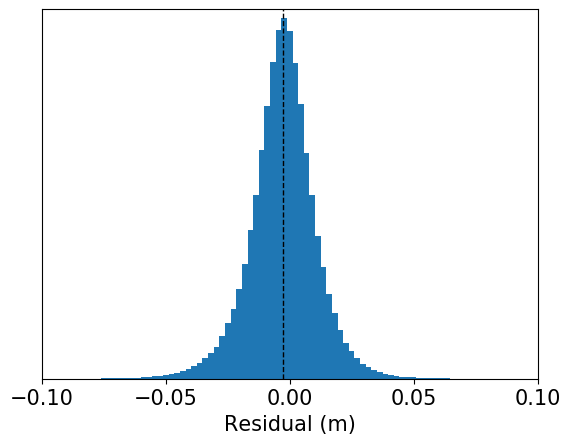

In [68]:
plt.hist(new_test.nn_model_prediction - new_test.ZTD, bins=250)
# plt.ylabel('Frequency')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 
plt.xlim(-0.1, 0.1)
plt.xlabel('Residual (m)', fontsize=15)
plt.xticks([-0.1,-0.05, 0 , 0.05, 0.1],fontsize=15)
plt.ylim(0, 39000)
plt.axvline((new_test.nn_model_prediction - new_test.ZTD).mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Plots/NN_residual_plot.png', dpi=250)
plt.show()

In [69]:
print("RF model")
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(new_test.ZTD, new_test.rf_Model_prediction))
print('Mean: %.5f' % np.mean(new_test.rf_Model_prediction-new_test.ZTD))

# The R2 score
print('R2: %.5f' % r2_score(new_test.ZTD, new_test.rf_Model_prediction))

# The RMSE
rmse = np.sqrt(mean_squared_error(new_test.ZTD, new_test.rf_Model_prediction))
print('RMSE: %.5f' % rmse)

errors = new_test.rf_Model_prediction - new_test.ZTD
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

RF model
Mean squared error: 0.0002184888
Mean: -0.00024
R2: 0.99309
RMSE: 0.01478
MAE: 0.01107


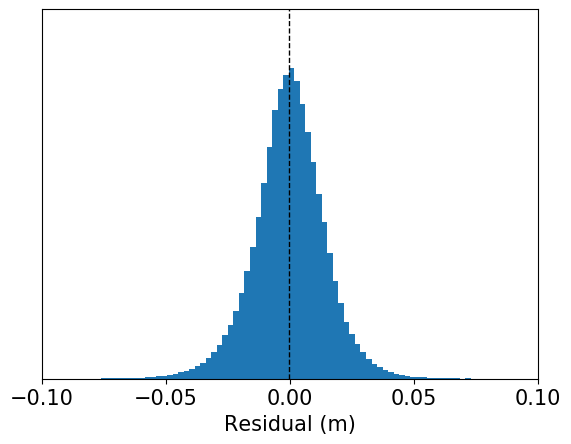

In [70]:
plt.hist(new_test.rf_Model_prediction - new_test.ZTD, bins=250)
plt.xlim(-0.1, 0.1)
plt.ylim(0, 39000)
# plt.ylabel('Frequency')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 
plt.xlabel('Residual (m)', fontsize=15)
plt.xticks([-0.1,-0.05, 0 , 0.05, 0.1],fontsize=15)
plt.axvline((new_test.rf_Model_prediction - new_test.ZTD).mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Plots/RF_residual_plot.png', dpi=250)
plt.show()

In [71]:
print("WM model")
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(new_test.ZTD, new_test.WM_ZTD))
print('Mean: %.5f' % np.mean(new_test.WM_ZTD-new_test.ZTD))

# The R2 score
print('R2: %.5f' % r2_score(new_test.ZTD, new_test.WM_ZTD))

# The RMSE
rmse = np.sqrt(mean_squared_error(new_test.ZTD, new_test.WM_ZTD))
print('RMSE: %.5f' % rmse)

errors = new_test.WM_ZTD - new_test.ZTD
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

WM model
Mean squared error: 0.0004067769
Mean: 0.01301
R2: 0.98713
RMSE: 0.02017
MAE: 0.01614


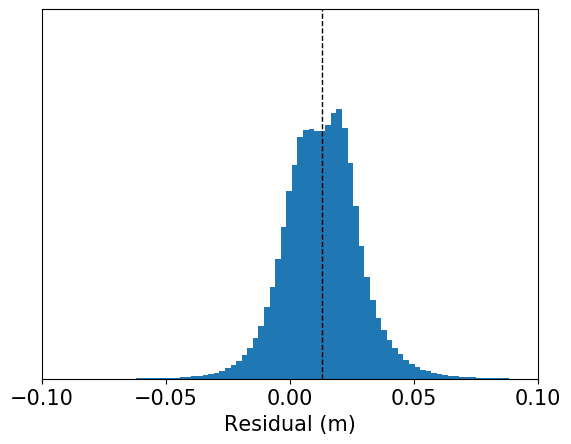

In [72]:
plt.hist(new_test.WM_ZTD - new_test.ZTD, bins=250)
plt.xlim(-0.1, 0.1)
plt.ylim(0, 39000)
# plt.ylabel('Frequency')
plt.xlabel('Residual (m)', fontsize=15)
plt.xticks([-0.1,-0.05, 0 , 0.05, 0.1],fontsize=15)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.axvline((new_test.WM_ZTD - new_test.ZTD).mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Plots/WM_residual_plot.png', dpi=250)
plt.show()

## Residual vs Elevation dependency

In [126]:
new_test

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  \
0          1082502  D143  2021-01-10  2.2784     0.0470             2.2314   
1          1082503  OHLC  2021-01-10  2.3306     0.0446             2.2860   
2          1082504  TGRI  2021-01-10  2.2803     0.1029             2.1774   
3          1082505  X059  2021-01-10  2.3109     0.0165             2.2944   
4          1082506  IABL  2021-01-10  2.3108     0.0415             2.2693   
...            ...   ...         ...     ...        ...                ...   
457475     1539977  J782  2022-10-17  2.3381     0.1235             2.2146   
457476     1539978  P080  2022-10-17  1.8765     0.0447             1.8318   
457477     1539979  GACE  2022-10-17  2.3348     0.1518             2.1830   
457478     1539980  TGBS  2022-10-17  2.4852     0.1728             2.3124   
457479     1539981  P397  2022-10-17  2.2313     0.0741             2.1572   

        times  sigZTD      Lat       Lon  ...      e_45      e_46      e_47  \
0           0  0.0026  50.7323   12.5203  ...  0.032060  0.027417  0.023558   
1           0  0.0026  41.7212  -83.5263  ...  0.033288  0.029017  0.025795   
2           0  0.0034 -38.9771  175.8585  ...  0.029205  0.023876  0.021358   
3           0  0.0037  34.8012  138.0731  ...  0.033044  0.028310  0.024358   
4           0  0.0027  40.7408  -92.4309  ...  0.033409  0.028564  0.024460   
...       ...     ...      ...       ...  ...       ...       ...       ...   
457475      0  0.0025  44.3651  142.2645  ...  0.039768  0.032811  0.027906   
457476      0  0.0023  39.1194 -114.2772  ...  0.043733  0.036500  0.029793   
457477      0  0.0027  34.5114  -83.5237  ...  0.041998  0.034082  0.028726   
457478      0  0.0026  53.5769    6.6614  ...  0.039257  0.032777  0.027944   
457479      0  0.0023  46.4216 -123.7992  ...  0.041095  0.034114  0.028796   

            e_48      e_49      e_50      e_51  rf_Model_prediction  \
0       0.012157  0.006304  0.002424 -0.001055             2.267286   
1       0.012191  0.006212  0.002963  0.001417             2.342560   
2       0.012107  0.006411  0.003133  0.000815             2.287976   
3       0.012449  0.006126  0.003159  0.000666             2.322539   
4       0.011663  0.006376  0.003002  0.001422             2.317579   
...          ...       ...       ...       ...                  ...   
457475  0.012748  0.006563  0.003218  0.001391             2.323491   
457476  0.012942  0.006629  0.003261  0.001381             1.872529   
457477  0.012957  0.006263  0.002832  0.001022             2.354305   
457478  0.013185  0.006485  0.003055  0.001409             2.459804   
457479  0.013295  0.006877  0.003150  0.001446             2.233227   

        nn_model_prediction    WM_ZTD  
0                  2.267729  2.273620  
1                  2.345321  2.355923  
2                  2.286639  2.301905  
3                  2.317984  2.325357  
4                  2.310547  2.335052  
...                     ...       ...  
457475             2.321986  2.341024  
457476             1.871174  1.891669  
457477             2.348444  2.367171  
457478             2.467183  2.470469  
457479             2.243631  2.254035  

[457480 rows x 167 columns]

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_Model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [562]:
RES_by_date = new_test.groupby('Date').mean()[['Lat', 'Lon', 'Hgt_m']]
RES_by_date['NN'] = (new_test['nn_model_prediction'] - new_test['ZTD']).groupby(new_test['Date']).mean()
RES_by_date['RF'] = (new_test['rf_Model_prediction'] - new_test['ZTD']).groupby(new_test['Date']).mean()
RES_by_date['WM'] = (new_test['WM_ZTD'] - new_test['ZTD']).groupby(new_test['Date']).mean()
RES_by_date['nn_avg_RMSE'] = new_test.groupby(['Date']).apply(rmse)['rmse']
RES_by_date['rf_avg_RMSE'] = new_test.groupby(['Date']).apply(rmse_)['rmse']
RES_by_date['wm_avg_RMSE'] = new_test.groupby(['Date']).apply(rmse__)['rmse']
RES_by_date = RES_by_date.reset_index()
RES_by_date

/tmp/ipykernel_18838/822036532.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  RES_by_date = new_test.groupby('Date').mean()[['Lat', 'Lon', 'Hgt_m']]


Date        Lat        Lon       Hgt_m        NN        RF  \
0   2021-01-10  33.395592 -22.446517  410.787004 -0.001445 -0.000009   
1   2021-01-25  33.398450 -23.123456  412.877940 -0.002043  0.000745   
2   2021-02-09  33.456205 -21.238801  414.030665 -0.003537 -0.001457   
3   2021-02-24  33.473423 -22.925159  415.924414  0.000266  0.001667   
4   2021-03-11  33.635336 -22.072610  412.728669 -0.001417  0.001289   
5   2021-03-26  33.443405 -21.417287  408.109778 -0.000456  0.002537   
6   2021-04-10  33.715566 -22.644514  412.276528 -0.001200  0.001010   
7   2021-04-25  33.762438 -22.109853  412.337656 -0.001928  0.000800   
8   2021-05-10  33.309144 -21.966740  418.266310 -0.004095  0.000234   
9   2021-05-25  33.419527 -22.076959  417.039738 -0.001914 -0.000817   
10  2021-06-09  33.729276 -22.783009  412.905549 -0.003452 -0.001124   
11  2021-06-24  33.708642 -22.084451  410.939006 -0.003886 -0.001989   
12  2021-07-09  33.365870 -20.468056  415.514107 -0.005588 -0.003102   
13  2021-07-24  33.357553 -21.559748  418.899544 -0.001193  0.000316   
14  2021-08-08  33.555618 -21.477739  417.918721 -0.003052 -0.001699   
15  2021-08-23  33.578581 -22.287587  418.793954 -0.001696  0.000939   
16  2021-09-07  33.914337 -22.233934  416.662867  0.000499  0.003224   
17  2021-09-22  33.637132 -22.330280  416.708728 -0.001691  0.000054   
18  2021-10-07  33.529572 -21.979126  412.412972  0.000035  0.000115   
19  2021-10-22  33.184370 -21.845490  411.223164 -0.000722  0.000548   
20  2021-11-06  33.532021 -21.698959  409.534718 -0.001905  0.000738   
21  2021-11-21  33.422548 -22.145214  415.016887  0.000030  0.000196   
22  2021-12-06  33.207183 -22.009712  410.258811 -0.001102 -0.000612   
23  2021-12-21  32.755142 -23.061644  412.223453 -0.001897  0.000373   
24  2022-01-05  32.587084 -23.321683  410.707057 -0.003133  0.000643   
25  2022-01-20  32.795742 -21.231945  415.781131 -0.002913 -0.001360   
26  2022-02-04  32.729534 -21.865453  416.896403 -0.004641 -0.003183   
27  2022-02-19  32.727528 -21.817720  415.972028 -0.003100 -0.000003   
28  2022-03-06  33.062838 -21.785823  410.731641 -0.003149  0.001031   
29  2022-03-21  33.014323 -20.865807  412.818005 -0.003348 -0.001457   
30  2022-04-05  32.636697 -21.028668  418.618704 -0.003679  0.000725   
31  2022-04-20  33.014613 -21.171346  410.519678 -0.002988  0.000358   
32  2022-05-05  33.044091 -21.319166  411.873276 -0.002859  0.000216   
33  2022-05-20  32.940878 -20.831651  414.846959 -0.004981  0.000488   
34  2022-06-04  32.585552 -21.800291  417.470755 -0.004045 -0.000071   
35  2022-06-19  32.740084 -20.725388  415.772757 -0.006793 -0.001376   
36  2022-07-04  32.278549 -21.576201  419.081016 -0.007294 -0.003231   
37  2022-07-19  32.233703 -20.443454  420.690509 -0.005648 -0.000865   
38  2022-08-03  32.167438 -21.052545  421.525733 -0.007493 -0.003367   
39  2022-08-18  32.342018 -20.805298  419.450950 -0.004832 -0.001777   
40  2022-09-02  32.565943 -20.865330  419.129208 -0.004173 -0.000738   
41  2022-09-17  32.063805 -28.804298  426.536585 -0.003556 -0.000623   
42  2022-10-02  32.487379 -21.281829  423.263027 -0.003074  0.000282   
43  2022-10-17  32.636846 -22.370847  421.301393 -0.002793 -0.000854   

          WM  nn_avg_RMSE  rf_avg_RMSE  wm_avg_RMSE  
0   0.012932     0.010156     0.010448     0.017242  
1   0.014737     0.010488     0.011778     0.019292  
2   0.013778     0.011452     0.012277     0.018081  
3   0.013179     0.010452     0.012397     0.017635  
4   0.013986     0.011919     0.013754     0.019216  
5   0.013371     0.011385     0.012485     0.019326  
6   0.012717     0.012673     0.013761     0.019153  
7   0.012314     0.011860     0.012998     0.018072  
8   0.012913     0.013199     0.012805     0.019031  
9   0.012899     0.013221     0.014327     0.019625  
10  0.013711     0.014669     0.015128     0.022464  
11  0.012865     0.016585     0.017721     0.022455  
12  0.014350     0.017305     0.017941     0.023015  
13  0.014914 

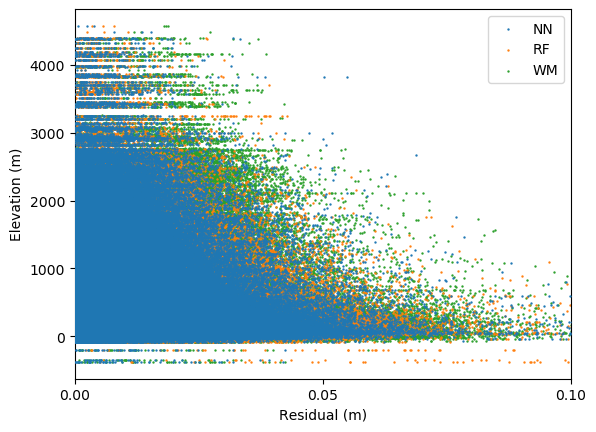

In [169]:
plt.scatter(np.abs(new_test.nn_model_prediction- new_test.ZTD), new_test.Hgt_m, s=0.5, zorder=3, label='NN')
plt.scatter(np.abs(new_test.rf_Model_prediction- new_test.ZTD), new_test.Hgt_m, s=0.5, zorder=2, label='RF')
plt.scatter(np.abs(new_test.WM_ZTD - new_test.ZTD), new_test.Hgt_m, s=0.5,  zorder=1,label='WM')
plt.xlim(0, 0.1)
plt.xticks([0, 0.05, 0.1])
plt.legend()
plt.xlabel('Residual (m)')
plt.ylabel('Elevation (m)')
plt.show()

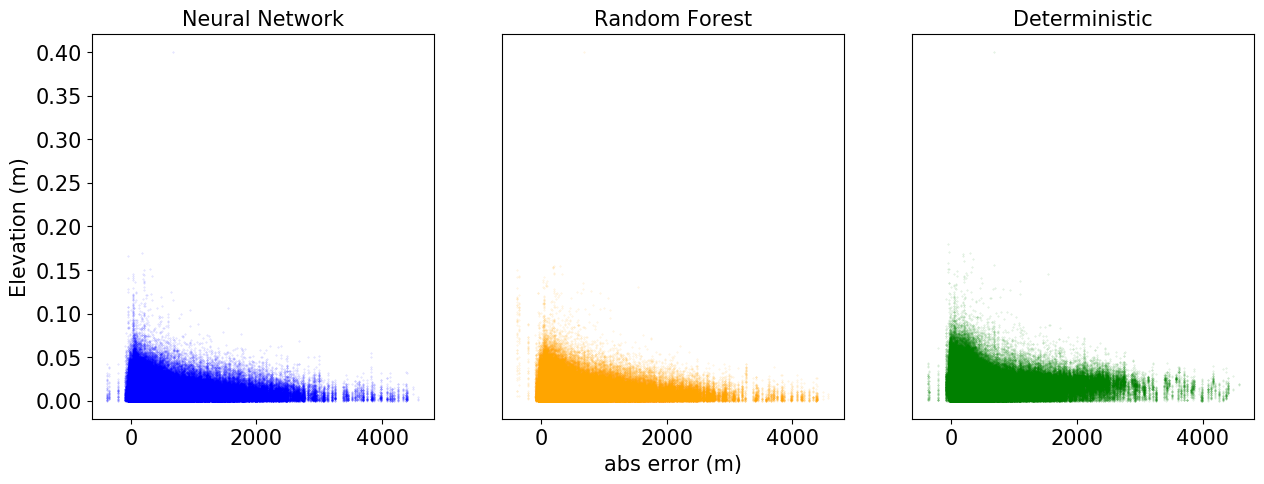

In [302]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].scatter(new_test.Hgt_m, np.abs(new_test.nn_model_prediction- new_test.ZTD),  c='blue', s=0.1, alpha=0.2)
axes[1].scatter(new_test.Hgt_m, np.abs(new_test.rf_Model_prediction- new_test.ZTD),  c='orange', s=0.1, alpha=0.2)
axes[2].scatter(new_test.Hgt_m, np.abs(new_test.WM_ZTD - new_test.ZTD),  c='green', s=0.1, alpha=0.2)
axes[0].set_title('Neural Network', fontsize=15)
axes[1].set_title('Random Forest', fontsize=15)
axes[2].set_title('Deterministic', fontsize=15)
for num ,i in enumerate(axes):
    if num==0:
        i.set_ylabel('Elevation (m)', fontsize=15)
        i.yaxis.set_tick_params(labelsize=15)
    elif num ==1:
        i.set_xlabel('abs error (m)', fontsize=15)
        i.set_yticks([])
    else:
        i.set_yticks([])
    # i.set_xlim(0,0.1)
    # i.set_xticks([0, 0.05, 0.1])
    i.xaxis.set_tick_params(labelsize=15)
# fig.savefig('Plots/Abs_resid_by_model.png', dpi=300)
plt.show()

## Residual through time

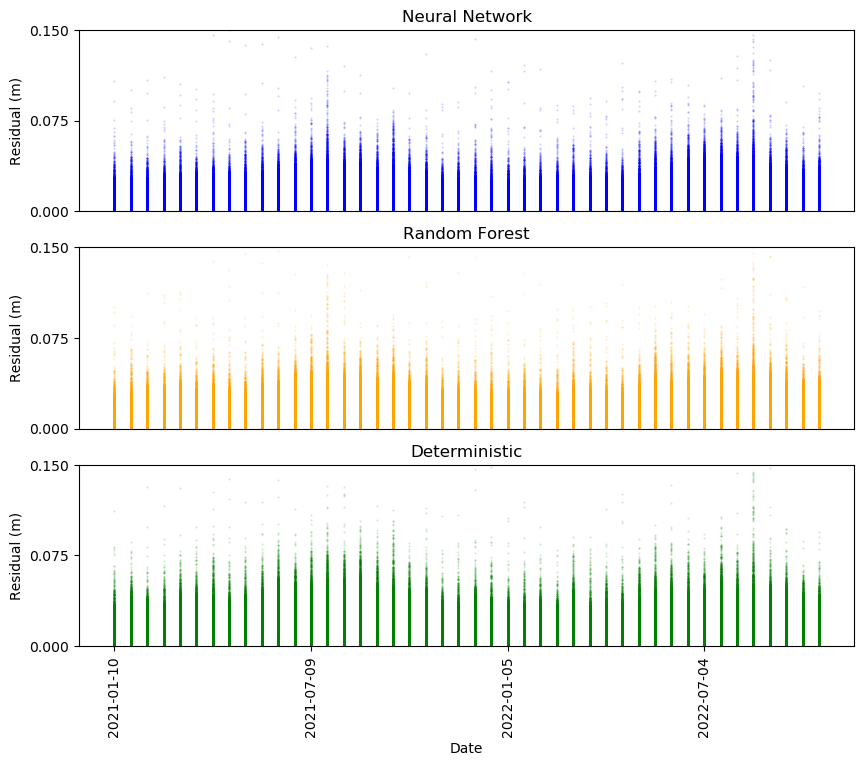

In [204]:
fig, axes=plt.subplots(3,1, figsize=(10,8))
axes[0].scatter(new_test.Date.values, np.abs(new_test.nn_model_prediction- new_test.ZTD).values, s=0.2, alpha=0.2, c='blue')
axes[1].scatter(new_test.Date.values, np.abs(new_test.rf_Model_prediction- new_test.ZTD).values, s=0.2, alpha=0.2, c='orange')
axes[2].scatter(new_test.Date.values, np.abs(new_test.WM_ZTD- new_test.ZTD).values, s=0.2, alpha=0.2, c='green')
axes[0].set_title('Neural Network')
axes[1].set_title('Random Forest')
axes[2].set_title('Deterministic')
for num ,i in enumerate(axes):
    if num==2:
        i.set_xticks(np.unique(new_test.Date)[::12])
        i.set_xticklabels(np.unique(new_test.Date)[::12], rotation=90)
        i.set_xlabel('Date')
    else:
        i.set_xticks([])
    i.set_ylim(0, 0.15)
    i.set_yticks([0,0.075,0.15])
    i.set_ylabel('Residual (m)', fontsize=10)

# fig.savefig('Plots/Abs_resid_by_model.png', dpi=300)
plt.show()

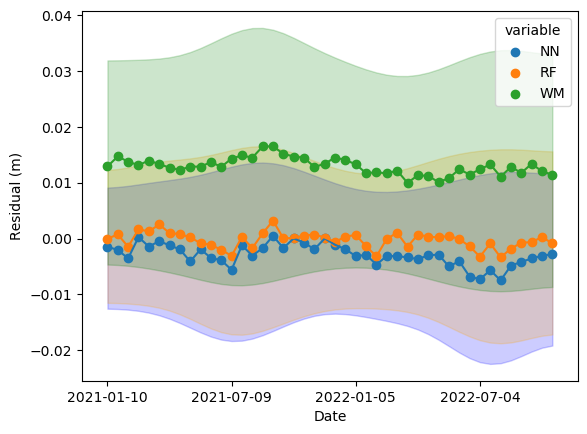

In [563]:
from scipy.ndimage import gaussian_filter1d
upper = gaussian_filter1d(RES_by_date.NN.values + RES_by_date.nn_avg_RMSE, sigma=3)
lower = gaussian_filter1d(RES_by_date.NN.values - RES_by_date.nn_avg_RMSE, sigma=3)
plt.fill_between(RES_by_date.Date.values, upper, lower, color='blue', alpha=0.2)
upper = gaussian_filter1d(RES_by_date.RF.values + RES_by_date.rf_avg_RMSE, sigma=3)
lower = gaussian_filter1d(RES_by_date.RF.values - RES_by_date.rf_avg_RMSE, sigma=3)
plt.fill_between(RES_by_date.Date.values, upper, lower, color='orange', alpha=0.2)
upper = gaussian_filter1d(RES_by_date.WM.values + RES_by_date.wm_avg_RMSE, sigma=3)
lower = gaussian_filter1d(RES_by_date.WM.values - RES_by_date.wm_avg_RMSE, sigma=3)
plt.fill_between(RES_by_date.Date.values, upper, lower, color='green', alpha=0.2)
plt.scatter(RES_by_date.Date.values, RES_by_date.NN.values, label='NN')
plt.scatter(RES_by_date.Date.values, RES_by_date.RF.values, label='RF')
plt.scatter(RES_by_date.Date.values, RES_by_date.WM.values, label='WM')
plt.plot(RES_by_date.Date.values, RES_by_date.NN.values)
plt.plot(RES_by_date.Date.values, RES_by_date.RF.values)
plt.plot(RES_by_date.Date.values, RES_by_date.WM.values)


plt.xticks(np.unique(RES_by_date.Date)[::12])
plt.xlabel('Date')
plt.ylabel('Residual (m)')
plt.legend(title='variable')
plt.show()

In [532]:
RES_by_date_melt = pd.melt(RES_by_date,id_vars=['Date','Lat', 'Lon', 'Hgt_m'], value_vars=['NN', 'RF', 'WM'])
RES_by_date_melt.head()

Date        Lat        Lon       Hgt_m variable     value
0  2021-01-10  33.395592 -22.446517  410.787004       NN -0.001445
1  2021-01-25  33.398450 -23.123456  412.877940       NN -0.002043
2  2021-02-09  33.456205 -21.238801  414.030665       NN -0.003537
3  2021-02-24  33.473423 -22.925159  415.924414       NN  0.000266
4  2021-03-11  33.635336 -22.072610  412.728669       NN -0.001417

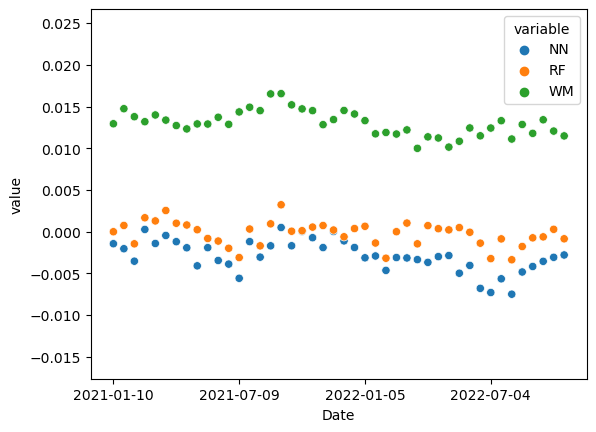

In [543]:
import seaborn as sns
s = sns.scatterplot(data =RES_by_date_melt, x='Date', y='value', hue='variable')
# a = sns.lineplot(date = RES_by_date_melt, x='Date', y='value', hue='variable')
s.set_xticks(np.unique(RES_by_date_melt.Date)[::12])
plt.show()

## Test at different time 6:00:00 UTC

In [168]:
hgtlvs = [ -100, 0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400
          ,2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000
          ,5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 11000, 12000, 13000
          ,14000, 15000, 16000, 17000, 18000, 19000, 20000, 25000, 30000, 35000, 40000]
import glob
# Function which is able to retrieve obtain the weather param for the GNSS and date
# file path: have to be the file where all the weather model are saved
# df : The list of combined data from downloading GNSS data using RAiDER Package
# Vertical: would like to interpolate everything from vertically from the lat lon
def extract_param_GNSS(df, wm_file_path: str, workLoc: str = '', vertical=False, fixed_hgt=False, batchsize=5000):
    def PTE_interp(wm, loc, df):
        # Create interpretor for each param
        P_interp = make_interpretor(wm, 'p')
        T_interp = make_interpretor(wm, 't')
        e_interp = make_interpretor(wm, 'e')

        # Interp the param
        df['P'] = (P_interp(loc)).values
        df['T'] = (T_interp(loc)).values
        df['e'] = (e_interp(loc)).values

        return df

    Date = np.sort(list(set(df['Date'])))
    for num, i in enumerate(Date):
        print(i)
        dd = df.loc[df['Date'] == i]
        date = i.replace('-', '_')  # Retrieve the date of the GNSS for NWM

        path_name = glob.glob(wm_file_path + 'ERA-5_{date}*[A-Z].nc'.format(date=date))
        print(path_name)
        try:
            ds = xr.load_dataset(" ".join(path_name))  # xr to read the weather model
            # dd = dd[(dd['Lon'] >= ds.x.min())& (dd['Lon']<= ds.x.max())&(dd['Lat'] >= ds.y.min())& (dd['Lat']<= ds.y.max())]
            loc = dd[['Lon', 'Lat', 'Hgt_m']].values
        except:
            print('Can not read weather model')
            continue
        if not vertical:
            # Create interpreter for each param
            data = PTE_interp(ds, loc, dd)
            if num == 0:
                print('Write file')
                data.to_csv(workLoc + 'PTE_interp.csv', index=False)
            else:
                print('Append to file')
                data.to_csv(workLoc + 'PTE_interp.csv', mode='a', index=False, header=False)
            print('Done', i)

        else:
            if fixed_hgt: 
                wm_param = []
                for iter in range(0, len(dd), batchsize):
                # Get coordinate of the GPS station
                    x = dd['Lon'].iloc[iter:iter+batchsize]
                    y = dd['Lat'].iloc[iter:iter+batchsize]
                    z = xr.DataArray(hgtlvs, dims='z')
                    # print(x, y)
                    p = ds.p.interp(x=x, y=y, z=z).values.transpose().diagonal().transpose()
                    t = ds.t.interp(x=x, y=y, z=z).values.transpose().diagonal().transpose()
                    e = ds.e.interp(x=x, y=y, z=z).values.transpose().diagonal().transpose()
                    wm_param.append(np.hstack((p,t,e)))
                wm_param = np.vstack(wm_param)
                data = pd.concat([dd.reset_index(drop=True), pd.DataFrame(wm_param).reset_index(drop=True)], axis=1, ignore_index=True)

                if num == 0:
                    name = ['P_' + str(i) for i in range(1, len(z) + 1)] + ['T_' + str(i) for i in
                                                                            range(1, len(z) + 1)] + ['e_' + str(i) for i
                                                                                                     in range(1,
                                                                                                              len(z) + 1)]
                    data.columns = np.concatenate((df.columns, name))
                    data.to_csv(workLoc + 'PTE_vert_fixed_hgtlvs.csv', index=False)
                else:
                    data.to_csv(workLoc + 'PTE_vert_fixed_hgtlvs.csv', mode='a', index=False, header=False)
                print('Done', i)

            else:
                wm_param = []
                for iter in range(0, len(dd), batchsize):
                    # Get coordinate of the GPS station
                    x = dd['Lon'].iloc[iter:iter+batchsize]
                    y = dd['Lat'].iloc[iter:iter+batchsize]
                    z = xr.DataArray(hgtlvs, dims='z')
                    # print(x, y)
                    p = ds.p.interp(x=x, y=y).values.transpose().diagonal().transpose()
                    t = ds.t.interp(x=x, y=y).values.transpose().diagonal().transpose()
                    e = ds.e.interp(x=x, y=y).values.transpose().diagonal().transpose()
                    wm_param.append(np.hstack((p,t,e)))
                wm_param = np.vstack(wm_param)
                data = pd.concat([dd.reset_index(drop=True), pd.DataFrame(wm_param).reset_index(drop=True)], axis=1, ignore_index=True)

                if num == 0:
                    name = ['P_' + str(i) for i in range(1, len(z) + 1)] + ['T_' + str(i) for i in
                                                                            range(1, len(z) + 1)] + ['e_' + str(i) for i
                                                                                                     in range(1,
                                                                                                              len(z) + 1)]
                    data.columns = np.concatenate((df.columns, name))
                    data.to_csv(workLoc + 'PTE_vert.csv', index=False)
                else:
                    data.to_csv(workLoc + 'PTE_vert.csv', mode='a', index=False, header=False)
                print('Done', i)
    print('Finished extraction.')

In [169]:
df = pd.read_csv('../GNSS_US/US_UTC_6/GNSS/UNRcombinedGPS_ztd.csv')
df = df[(df['sigZTD']<0.01)&(df['sigZTD']!=0)].reset_index(drop=True)

print('Data Frame length:', len(df))
extract_param_GNSS(df,'../GNSS_US/US_UTC_6/weather_files/', '../GNSS_US/US_UTC_6/global_UTC6_', vertical=True, fixed_hgt=True)

Data Frame length: 556253
2017-01-01
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_01_01_T06_00_00_23N_54N_125W_69W.nc']
Done 2017-01-01
2017-01-16
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_01_16_T06_00_00_23N_54N_125W_69W.nc']
Done 2017-01-16
2017-01-31
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_01_31_T06_00_00_23N_54N_125W_69W.nc']
Done 2017-01-31
2017-02-15
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_02_15_T06_00_00_23N_54N_125W_69W.nc']
Done 2017-02-15
2017-03-02
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_03_02_T06_00_00_23N_54N_125W_69W.nc']
Done 2017-03-02
2017-03-17
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_03_17_T06_00_00_23N_54N_125W_69W.nc']
Done 2017-03-17
2017-04-01
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_04_01_T06_00_00_23N_54N_125W_69W.nc']
Done 2017-04-01
2017-04-16
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_04_16_T06_00_00_23N_54N_125W_69W.nc']
Done 2017-04-16
2017-05-01
['../GNSS_US/US_UTC_6/weather_files/ERA-5_2017_05_01_T06_00_00_23N_

In [3]:
global_UTC6 = pd.read_csv('../GNSS_US/US_UTC_6/global_UTC6_PTE_vert_fixed_hgtlvs.csv')

In [4]:
global_UTC6.head()

ID        Date     ZTD  wet_delay  hydrostatic_delay  times  sigZTD  \
0  1NSU  2017-01-01  2.4891     0.1950             2.2941  21600  0.0017   
1  1ULM  2017-01-01  2.4765     0.1780             2.2985  21600  0.0016   
2  7ODM  2017-01-01  2.1770     0.0842             2.0928  21600  0.0019   
3  ABL1  2017-01-01  2.2835     0.1149             2.1686  21600  0.0016   
4  ABLT  2017-01-01  2.0904     0.0387             2.0517  21600  0.0017   

       Lat       Lon    Hgt_m  ...      e_42      e_43      e_44      e_45  \
0  31.7508  -93.0976   28.071  ...  0.081098  0.048355  0.035053  0.031020   
1  32.5290  -92.0759   16.000  ...  0.086304  0.049538  0.034963  0.030968   
2  34.1164 -117.0932  762.072  ...  0.051236  0.043367  0.037930  0.033653   
3  32.4537  -99.7305  501.964  ...  0.067384  0.044615  0.034657  0.030806   
4  49.7062 -112.8353  896.343  ...  0.052580  0.045216  0.038925  0.033145   

       e_46      e_47      e_48      e_49      e_50      e_51  
0  0.027552  0.024452  0.012535  0.006338  0.003060  0.001227  
1  0.027522  0.024434  0.012531  0.006333  0.003059  0.001243  
2  0.029391  0.025140  0.011809  0.006087  0.003064  0.001425  
3  0.027428  0.024356  0.011822  0.006070  0.003061  0.001314  
4  0.028490  0.024567  0.012337  0.005988  0.002889  0.001438  

[5 rows x 163 columns]

In [5]:
# Load model and scaler
from joblib import dump, load
import tensorflow as tf
rf_model = load('Model/Global_PTE_fixed_hgtlvs_RF.joblib') # This take a very long time to load because of it's 16 GB
nn_model = tf.keras.models.load_model('Model/global_PTE_fixed_hgtlvs_02_20_model')
scaler_x = load('Scaler/global_MinMax_scaler_x.bin')

2023-05-03 15:59:27.130977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
inputs = global_UTC6.iloc[:, global_UTC6.columns.str.startswith(('Lat', 'Hgt_m','P_', 'T_', 'e_'))]
global_UTC6['nn_model_prediction'] = nn_model.predict(scaler_x.transform(inputs))
true = global_UTC6.ZTD.values

17383/17383 [==============================] - 12s 633us/step


In [8]:
# Predict different model
predict = global_UTC6['nn_model_prediction'].values
# true = y_test.values

from sklearn.metrics import mean_squared_error, r2_score

print("ANN model")
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))
# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict))
print('RMSE: %.5f' % rmse)

errors = predict - true
print('Average error: %.5f' % np.mean(abs(errors)))

ANN model
Mean squared error: 0.0001358194
Mean: 0.00202
R2: 0.99649
RMSE: 0.01165
Average error: 0.00852


# Metric by Continent

## Scatter plot of elevation and RMSE by continent

Use pandas to read in the categrozied station by continent which we can merge these information with the other dataframe

In [4]:
station_con = pd.read_csv('station_continent.csv')
station_con.head()

ID CONTINENT
0  0ABI    Africa
1  0ABY    Europe
2  0AKE    Europe
3  0ALE    Europe
4  0ALF    Europe

In [5]:
new_test_continent = pd.merge(new_test, station_con, on=["ID"])

In [156]:
new_test_continent.head()

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  times  \
0     1082502  D143  2021-01-10  2.2784     0.0470             2.2314      0   
1     1093335  D143  2021-01-25  2.2190     0.0394             2.1796      0   
2     1103948  D143  2021-02-09  2.2150     0.0346             2.1804      0   
3     1114353  D143  2021-02-24  2.3439     0.0836             2.2603      0   
4     1125022  D143  2021-03-11  2.2942     0.0825             2.2117      0   

   sigZTD      Lat      Lon  ...      e_46      e_47      e_48      e_49  \
0  0.0026  50.7323  12.5203  ...  0.027417  0.023558  0.012157  0.006304   
1  0.0026  50.7323  12.5203  ...  0.028593  0.025330  0.012363  0.006484   
2  0.0027  50.7323  12.5203  ...  0.028408  0.024498  0.012435  0.006266   
3  0.0024  50.7323  12.5203  ...  0.030922  0.026464  0.011949  0.006317   
4  0.0026  50.7323  12.5203  ...  0.027812  0.023908  0.011930  0.006138   

       e_50      e_51  rf_Model_prediction  nn_model_prediction    WM_ZTD  \
0  0.002424 -0.001055             2.267286             2.267729  2.273620   
1  0.002100 -0.002192             2.210145             2.213663  2.223226   
2  0.003011  0.001116             2.205041             2.197710  2.223079   
3  0.003030  0.001441             2.339764             2.346157  2.349665   
4  0.002986  0.001048             2.297924             2.289177  2.303688   

   CONTINENT  
0     Europe  
1     Europe  
2     Europe  
3     Europe  
4     Europe  

[5 rows x 168 columns]

In [7]:
error_stat_cont = new_test_continent.groupby(['CONTINENT', 'ID']).mean()

/tmp/ipykernel_57311/4025404414.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_stat_cont = new_test_continent.groupby(['CONTINENT', 'ID']).mean()


In [8]:
error_stat_cont.head()

Unnamed: 0       ZTD  wet_delay  hydrostatic_delay  times  \
CONTINENT ID                                                                  
Africa    0ABI  1.314028e+06  2.240380   0.060875           2.179505    0.0   
          ABPO  1.314594e+06  2.053920   0.117302           1.936618    0.0   
          ACRG  1.235107e+06  2.590185   0.294238           2.295946    0.0   
          ADIS  1.387497e+06  1.846559   0.112365           1.734194    0.0   
          ALWN  1.212515e+06  2.081517   0.092083           1.989433    0.0   

                  sigZTD      Lat      Lon     Hgt_m           P_1  ...  \
CONTINENT ID                                                        ...   
Africa    0ABI  0.002411  68.3543  18.8164   431.388  97784.613646  ...   
          ABPO  0.002518 -19.0183  47.2292  1552.968  95733.049854  ...   
          ACRG  0.002788   5.6415  -0.2071    84.483  97815.650216  ...   
          ADIS  0.003059   9.0351  38.7663  2439.166  95119.399532  ...   
          ALWN  0.002508 -30.6467  26.5530  1357.346  96196.439247  ...   

                    e_45      e_46      e_47      e_48      e_49      e_50  \
CONTINENT ID                                                                 
Africa    0ABI  0.034774  0.030183  0.026388  0.013017  0.006721  0.003070   
          ABPO  0.039455  0.031100  0.026034  0.011981  0.005978  0.002887   
          ACRG  0.039128  0.030894  0.025922  0.011674  0.005891  0.002757   
          ADIS  0.038787  0.031358  0.026413  0.011922  0.005955  0.002822   
          ALWN  0.036121  0.030045  0.025526  0.012260  0.006180  0.002982   

                    e_51  rf_Model_prediction  nn_model_prediction    WM_ZTD  
CONTINENT ID                                                                  
Africa    0ABI  0.000811             2.238568             2.236751  2.249014  
          ABPO  0.001163             2.058220             2.057068  2.070331  
          ACRG  0.001011             2.585976             2.579857  2.597876  
          ADIS  0.001100             1.847983             1.852910  1.874937  
          ALWN  0.001170             2.070280             2.073816  2.084070  

[5 rows x 165 columns]

In [11]:
# error_stat_cont['nn_Avg_error'] = (new_test_continent.nn_model_prediction-new_test_continent.ZTD).groupby(['CONTINENT', 'ID']).mean()
error_stat_cont['nn_RMSE'] = new_test_continent.groupby(['CONTINENT', 'ID']).apply(rmse)['rmse']
# error_stat_cont['rf_Avg_error'] = (new_test_continent.rf_Model_prediction-new_test_continent.ZTD).groupby(['CONTINENT', 'ID']).mean()
error_stat_cont['rf_RMSE'] = new_test_continent.groupby(['CONTINENT', 'ID']).apply(rmse_)['rmse']
# error_stat_cont['wm_Avg_error'] = (new_test_continent.WM_ZTD-new_test_continent.ZTD).groupby(['CONTINENT', 'ID']).mean()
error_stat_cont['wm_RMSE'] = new_test_continent.groupby(['CONTINENT', 'ID']).apply(rmse__)['rmse']

In [12]:
error_stat_cont['CONT'] = [ x[0] for x in error_stat_cont.index]

In [13]:
melt_table = pd.melt(error_stat_cont,id_vars=['CONT', 'Hgt_m'], value_vars=['nn_RMSE', 'rf_RMSE', 'wm_RMSE'])

In [14]:
melt_table.head()

CONT     Hgt_m variable     value
0  Africa   431.388  nn_RMSE  0.007216
1  Africa  1552.968  nn_RMSE  0.013091
2  Africa    84.483  nn_RMSE  0.021903
3  Africa  2439.166  nn_RMSE  0.015397
4  Africa  1357.346  nn_RMSE  0.012410

In [15]:
error_stat_cont.head()

Unnamed: 0       ZTD  wet_delay  hydrostatic_delay  times  \
CONTINENT ID                                                                  
Africa    0ABI  1.314028e+06  2.240380   0.060875           2.179505    0.0   
          ABPO  1.314594e+06  2.053920   0.117302           1.936618    0.0   
          ACRG  1.235107e+06  2.590185   0.294238           2.295946    0.0   
          ADIS  1.387497e+06  1.846559   0.112365           1.734194    0.0   
          ALWN  1.212515e+06  2.081517   0.092083           1.989433    0.0   

                  sigZTD      Lat      Lon     Hgt_m           P_1  ...  \
CONTINENT ID                                                        ...   
Africa    0ABI  0.002411  68.3543  18.8164   431.388  97784.613646  ...   
          ABPO  0.002518 -19.0183  47.2292  1552.968  95733.049854  ...   
          ACRG  0.002788   5.6415  -0.2071    84.483  97815.650216  ...   
          ADIS  0.003059   9.0351  38.7663  2439.166  95119.399532  ...   
          ALWN  0.002508 -30.6467  26.5530  1357.346  96196.439247  ...   

                    e_49      e_50      e_51  rf_Model_prediction  \
CONTINENT ID                                                        
Africa    0ABI  0.006721  0.003070  0.000811             2.238568   
          ABPO  0.005978  0.002887  0.001163             2.058220   
          ACRG  0.005891  0.002757  0.001011             2.585976   
          ADIS  0.005955  0.002822  0.001100             1.847983   
          ALWN  0.006180  0.002982  0.001170             2.070280   

                nn_model_prediction    WM_ZTD   nn_RMSE   rf_RMSE   wm_RMSE  \
CONTINENT ID                                                                  
Africa    0ABI             2.236751  2.249014  0.007216  0.007411  0.010152   
          ABPO             2.057068  2.070331  0.013091  0.012484  0.020256   
          ACRG             2.579857  2.597876  0.021903  0.021604  0.023209   
          ADIS             1.852910  1.874937  0.015397  0.015410  0.031526   
          ALWN             2.073816  2.084070  0.012410  0.016272  0.008986   

                  CONT  
CONTINENT ID            
Africa    0ABI  Africa  
          ABPO  Africa  
          ACRG  Africa  
          ADIS  Africa  
          ALWN  Africa  

[5 rows x 169 columns]

In [60]:
add_new_test = new_test.copy()
add_new_test = add_new_test.groupby(['ID']).mean()
# error_stat_cont['nn_Avg_error'] = (new_test_continent.nn_model_prediction-new_test_continent.ZTD).groupby(['CONTINENT', 'ID']).mean()
add_new_test['nn_RMSE'] = add_new_test.groupby(['ID']).apply(rmse)['rmse']
# error_stat_cont['rf_Avg_error'] = (new_test_continent.rf_Model_prediction-new_test_continent.ZTD).groupby(['CONTINENT', 'ID']).mean()
add_new_test['rf_RMSE'] = add_new_test.groupby(['ID']).apply(rmse_)['rmse']
# error_stat_cont['wm_Avg_error'] = (new_test_continent.WM_ZTD-new_test_continent.ZTD).groupby(['CONTINENT', 'ID']).mean()
add_new_test['wm_RMSE'] = add_new_test.groupby(['ID']).apply(rmse__)['rmse']
add_new_test['CONTINENT'] = 'Global'
add_new_test

/tmp/ipykernel_57311/1404640960.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  add_new_test = add_new_test.groupby(['ID']).mean()


Unnamed: 0       ZTD  wet_delay  hydrostatic_delay  times    sigZTD  \
ID                                                                            
0ABI  1.314028e+06  2.240380   0.060875           2.179505    0.0  0.002411   
0ABY  1.316737e+06  2.384332   0.093248           2.291084    0.0  0.002214   
0AKE  1.315761e+06  2.384377   0.090986           2.293391    0.0  0.002261   
0ALE  1.318809e+06  2.304998   0.076395           2.228602    0.0  0.002284   
0ALF  1.314161e+06  2.349534   0.084216           2.265318    0.0  0.002264   
...            ...       ...        ...                ...    ...       ...   
ZWEV  1.487804e+06  2.455333   0.150789           2.304544    0.0  0.002367   
ZWO2  1.307402e+06  2.412845   0.107955           2.304890    0.0  0.002471   
ZYRA  1.273751e+06  2.372610   0.092665           2.279945    0.0  0.002805   
ZYWI  1.307043e+06  2.326100   0.110251           2.215849    0.0  0.002420   
ZZON  1.469760e+06  2.400508   0.137077           2.263431    0.0  0.002454   

          Lat      Lon    Hgt_m           P_1  ...      e_49      e_50  \
ID                                             ...                       
0ABI  68.3543  18.8164  431.388  97784.613646  ...  0.006721  0.003070   
0ABY  58.6589  16.1796   60.548  96834.056788  ...  0.006780  0.003177   
0AKE  59.4814  18.3020   43.131  96754.030078  ...  0.006747  0.003164   
0ALE  62.7805  16.0137  272.454  97178.394891  ...  0.006774  0.003126   
0ALF  61.3445  16.0649  142.743  97205.356025  ...  0.006771  0.003158   
...       ...      ...      ...           ...  ...       ...       ...   
ZWEV  50.8231   3.3456   76.180  95599.611176  ...  0.007292  0.003393   
ZWO2  52.5028   6.0934   65.610  97029.162539  ...  0.006797  0.003208   
ZYRA  52.0548  20.4203  157.400  96606.669175  ...  0.006674  0.003162   
ZYWI  49.6867  19.2060  412.779  96322.102686  ...  0.006886  0.003250   
ZZON  46.8914  16.8320  252.843  96398.297571  ...  0.007113  0.003355   

          e_51  rf_Model_prediction  nn_model_prediction    WM_ZTD   nn_RMSE  \
ID                                                                             
0ABI  0.000811             2.238568             2.236751  2.249014  0.003628   
0ABY  0.000944             2.383474             2.379727  2.388727  0.004605   
0AKE  0.000953             2.381322             2.380810  2.389516  0.003568   
0ALE  0.000924             2.302740             2.301515  2.311721  0.003482   
0ALF  0.000942             2.349247             2.345494  2.354788  0.004040   
...        ...                  ...                  ...       ...       ...   
ZWEV  0.001074             2.453867             2.444618  2.454779  0.010715   
ZWO2  0.000938             2.408971             2.404247  2.414846  0.008598   
ZYRA  0.000952             2.367122             2.366281  2.378272  0.006329   
ZYWI  0.000945             2.319618             2.319619  2.331683  0.006481   
ZZON  0.001150             2.387022             2.386323  2.399124  0.014185   

       rf_RMSE   wm_RMSE  CONTINENT  
ID                                   
0ABI  0.001811  0.008635     Global  
0ABY  0.000858  0.004395     Global  
0AKE  0.003056  0.005139     Global  
0ALE  0.002257  0.006723     Global  
0ALF  0.000287  0.005254     Global  
...        ...       ...        ...  
ZWEV  0.001466  0.000554     Global  
ZWO2  0.003874  0.002001     Global  
ZYRA  0.005488  0.005662     Global  
ZYWI  0.006482  0.005583     Global  
ZZON  0.013486  0.001384     Global  

[12979 rows x 169 columns]

In [65]:
join_table = pd.concat([error_stat_cont.reset_index(), add_new_test.reset_index()])

In [67]:
join_table

CONTINENT    ID    Unnamed: 0       ZTD  wet_delay  hydrostatic_delay  \
0        Africa  0ABI  1.314028e+06  2.240380   0.060875           2.179505   
1        Africa  ABPO  1.314594e+06  2.053920   0.117302           1.936618   
2        Africa  ACRG  1.235107e+06  2.590185   0.294238           2.295946   
3        Africa  ADIS  1.387497e+06  1.846559   0.112365           1.734194   
4        Africa  ALWN  1.212515e+06  2.081517   0.092083           1.989433   
...         ...   ...           ...       ...        ...                ...   
12974    Global  ZWEV  1.487804e+06  2.455333   0.150789           2.304544   
12975    Global  ZWO2  1.307402e+06  2.412845   0.107955           2.304890   
12976    Global  ZYRA  1.273751e+06  2.372610   0.092665           2.279945   
12977    Global  ZYWI  1.307043e+06  2.326100   0.110251           2.215849   
12978    Global  ZZON  1.469760e+06  2.400508   0.137077           2.263431   

       times    sigZTD      Lat      Lon  ...      e_49      e_50      e_51  \
0        0.0  0.002411  68.3543  18.8164  ...  0.006721  0.003070  0.000811   
1        0.0  0.002518 -19.0183  47.2292  ...  0.005978  0.002887  0.001163   
2        0.0  0.002788   5.6415  -0.2071  ...  0.005891  0.002757  0.001011   
3        0.0  0.003059   9.0351  38.7663  ...  0.005955  0.002822  0.001100   
4        0.0  0.002508 -30.6467  26.5530  ...  0.006180  0.002982  0.001170   
...      ...       ...      ...      ...  ...       ...       ...       ...   
12974    0.0  0.002367  50.8231   3.3456  ...  0.007292  0.003393  0.001074   
12975    0.0  0.002471  52.5028   6.0934  ...  0.006797  0.003208  0.000938   
12976    0.0  0.002805  52.0548  20.4203  ...  0.006674  0.003162  0.000952   
12977    0.0  0.002420  49.6867  19.2060  ...  0.006886  0.003250  0.000945   
12978    0.0  0.002454  46.8914  16.8320  ...  0.007113  0.003355  0.001150   

       rf_Model_prediction  nn_model_prediction    WM_ZTD   nn_RMSE   rf_RMSE  \
0                 2.238568             2.236751  2.249014  0.007216  0.007411   
1                 2.058220             2.057068  2.070331  0.013091  0.012484   
2                 2.585976             2.579857  2.597876  0.021903  0.021604   
3                 1.847983             1.852910  1.874937  0.015397  0.015410   
4                 2.070280             2.073816  2.084070  0.012410  0.016272   
...                    ...                  ...       ...       ...       ...   
12974             2.453867             2.444618  2.454779  0.010715  0.001466   
12975             2.408971             2.404247  2.414846  0.008598  0.003874   
12976             2.367122             2.366281  2.378272  0.006329  0.005488   
12977             2.319618             2.319619  2.331683  0.006481  0.006482   
12978             2.387022             2.386323  2.399124  0.014185  0.013486   

        wm_RMSE    CONT  
0      0.010152  Africa  
1      0.020256  Africa  
2      0.023209  Africa  
3      0.031526  Africa  
4      0.008986  Africa  
...         ...     ...  
12974  0.000554     NaN  
12975  0.002001     NaN  
12976  0.005662     NaN  
12977  0.005583     NaN  
12978  0.001384     NaN  

[25927 rows x 171 columns]

### Normal Linear Model

Text(0.5, 0.98, 'NN model')

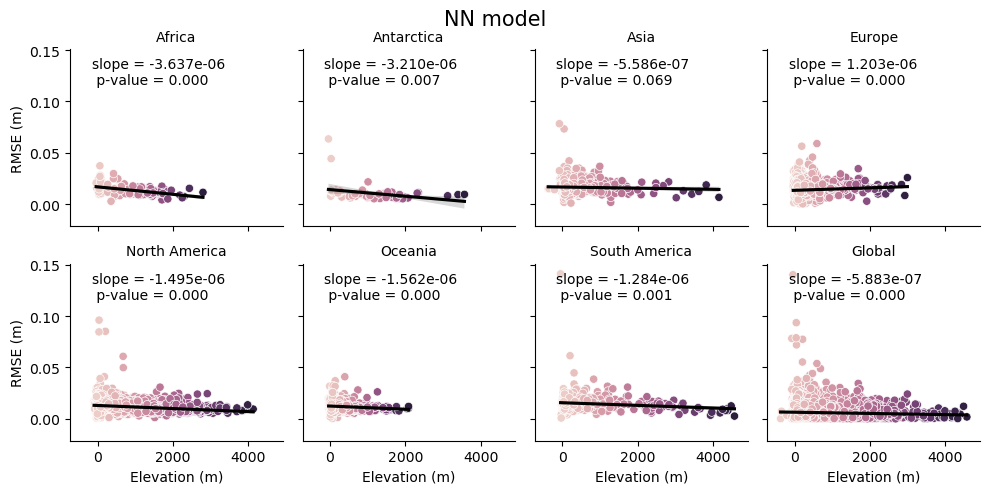

In [142]:
import seaborn as sns
from scipy import stats
def annotate(data, **kws):
    model = stats.linregress(data['Hgt_m'], data['nn_RMSE'])
    ax = plt.gca()
    ax.text(.1, .8, f"slope = {model.slope:.3e} \n p-value = {model.pvalue:.3f}", transform=ax.transAxes)
g = sns.FacetGrid(join_table, col='CONTINENT', height=2.5, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="Hgt_m", y="nn_RMSE", hue='Hgt_m' )
g.map_dataframe(sns.regplot, x="Hgt_m", y="nn_RMSE", scatter=False, color='black')
g.set_titles("{col_name}")
g.set_axis_labels('Elevation (m)', 'RMSE (m)')
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('NN model', fontsize=15)

Text(0.5, 0.98, 'RF model')

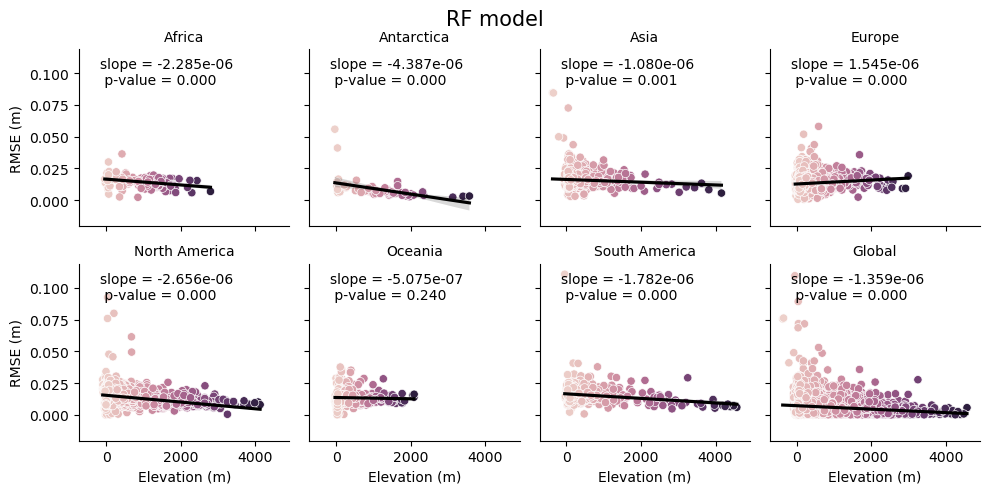

In [ ]:
import seaborn as sns
from scipy import stats
def annotate(data, **kws):
    model = stats.linregress(data['Hgt_m'], data['rf_RMSE'])
    ax = plt.gca()
    ax.text(.1, .8, f"slope = {model.slope:.3e} \n p-value = {model.pvalue:.3f}", transform=ax.transAxes)
g = sns.FacetGrid(join_table, col='CONTINENT', height=2.5, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="Hgt_m", y="rf_RMSE", hue='Hgt_m' )
g.map_dataframe(sns.regplot, x="Hgt_m", y="rf_RMSE", scatter=False, color='black')
g.set_titles("{col_name}")
g.set_axis_labels('Elevation (m)', 'RMSE (m)')
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('RF model', fontsize=15)

Text(0.5, 0.98, 'WM model')

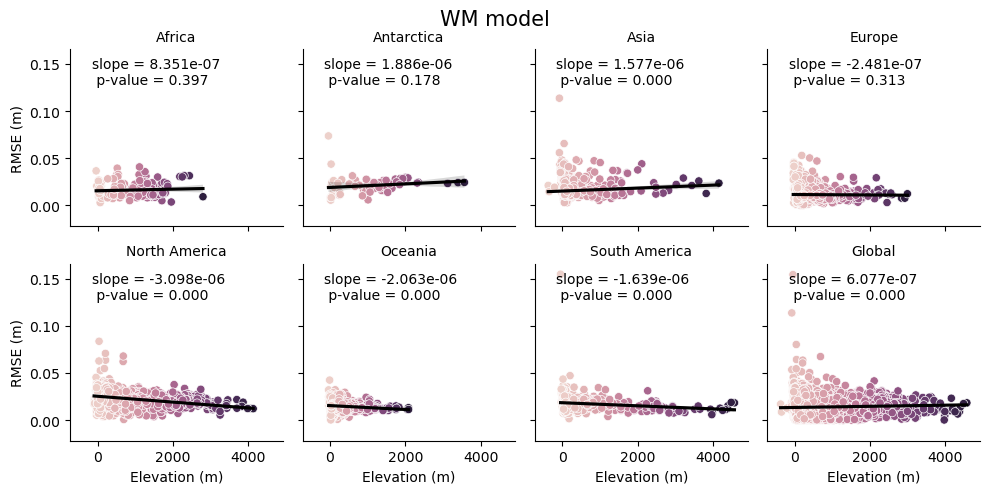

In [145]:
import seaborn as sns
from scipy import stats
def annotate(data, **kws):
    model = stats.linregress(data['Hgt_m'], data['wm_RMSE'])
    ax = plt.gca()
    ax.text(.1, .8, f"slope = {model.slope:.3e} \n p-value = {model.pvalue:.3f}", transform=ax.transAxes)
g = sns.FacetGrid(join_table, col='CONTINENT', height=2.5, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="Hgt_m", y="wm_RMSE", hue='Hgt_m' )
g.map_dataframe(sns.regplot, x="Hgt_m", y="wm_RMSE", scatter=False, color='black')
g.set_titles("{col_name}")
g.set_axis_labels('Elevation (m)', 'RMSE (m)')
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('WM model', fontsize=15)

### Robust Linear Model

In [79]:
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor

Text(0.5, 0.98, 'NN model')

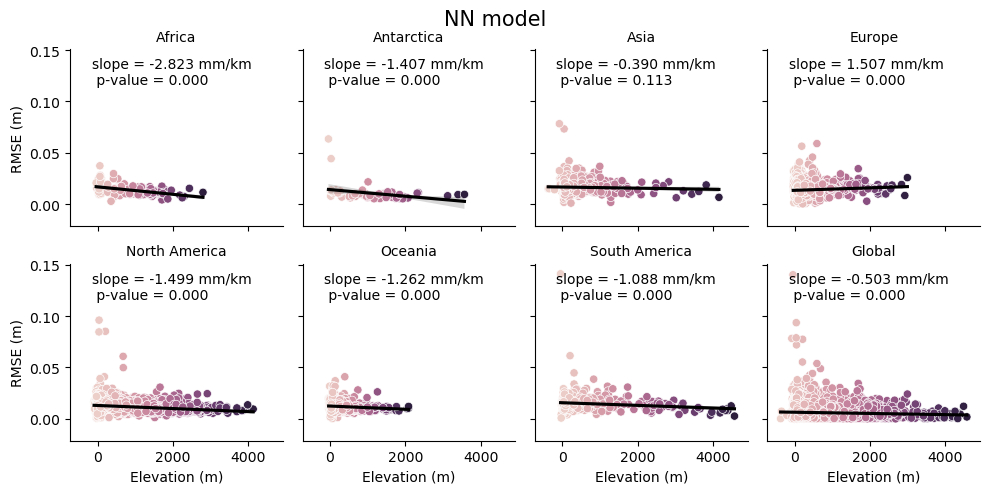

In [155]:
import seaborn as sns
from scipy import stats
def annotate(data, **kws):
    model = sm.RLM(data['nn_RMSE'].values.reshape(-1,1),sm.add_constant(data['Hgt_m']), M=sm.robust.norms.HuberT()).fit()
    ax = plt.gca()
    ax.text(.1, .8, f"slope = {model.params[1]/(10**(-6)):.3f} mm/km \n p-value = {model.pvalues[1]:.3f}", transform=ax.transAxes)
g = sns.FacetGrid(join_table, col='CONTINENT', height=2.5, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="Hgt_m", y="nn_RMSE", hue='Hgt_m' )
g.map_dataframe(sns.regplot, x="Hgt_m", y="nn_RMSE", scatter=False, color='black')
g.set_titles("{col_name}")
g.set_axis_labels('Elevation (m)', 'RMSE (m)')
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('NN model', fontsize=15)

Text(0.5, 0.98, 'RF model')

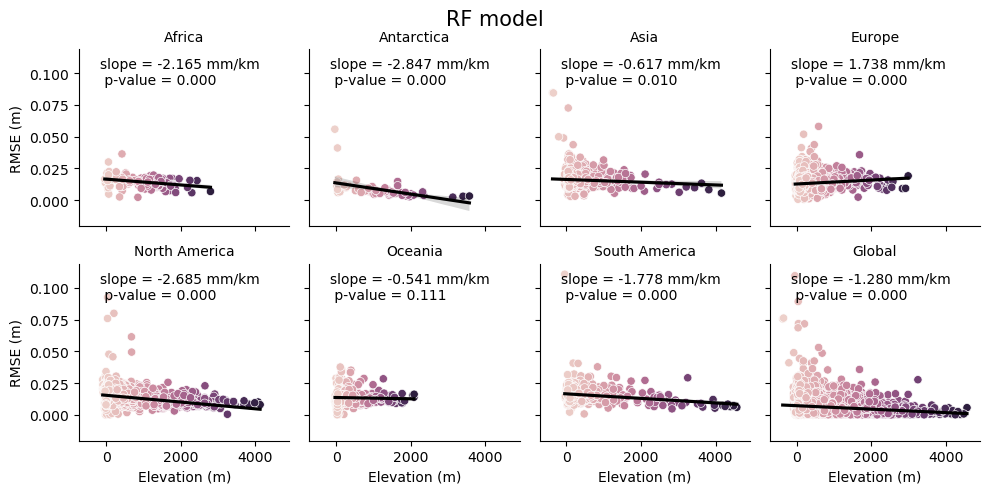

In [152]:
import seaborn as sns
from scipy import stats
def annotate(data, **kws):
    model = sm.RLM(data['rf_RMSE'].values.reshape(-1,1),sm.add_constant(data['Hgt_m']), M=sm.robust.norms.HuberT()).fit()
    ax = plt.gca()
    ax.text(.1, .8, f"slope = {model.params[1]/(10**(-6)):.3f} mm/km \n p-value = {model.pvalues[1]:.3f}", transform=ax.transAxes)
    
g = sns.FacetGrid(join_table, col='CONTINENT', height=2.5, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="Hgt_m", y="rf_RMSE", hue='Hgt_m')
g.map_dataframe(sns.regplot, x="Hgt_m", y="rf_RMSE", scatter=False, color='black')
g.set_titles("{col_name}")
g.set_axis_labels('Elevation (m)', 'RMSE (m)')
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('RF model', fontsize=15)

Text(0.5, 0.98, 'WM model')

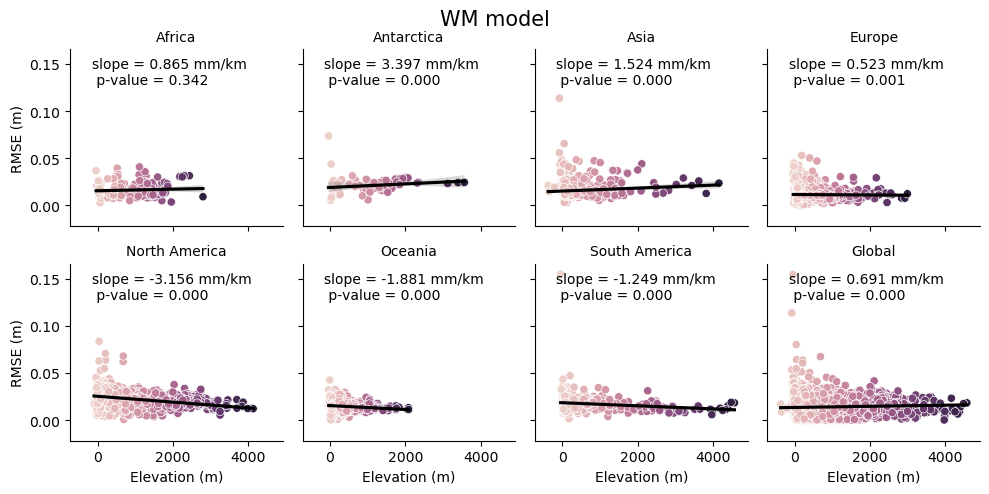

In [153]:
import seaborn as sns
from scipy import stats 
def annotate(data, **kws):
    model = sm.RLM(data['wm_RMSE'].values.reshape(-1,1),sm.add_constant(data['Hgt_m']), M=sm.robust.norms.HuberT()).fit()
    ax = plt.gca()
    ax.text(.1, .8, f"slope = {model.params[1]/(10**(-6)):.3f} mm/km \n p-value = {model.pvalues[1]:.3f}", transform=ax.transAxes)

g = sns.FacetGrid(join_table, col='CONTINENT', height=2.5, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="Hgt_m", y="wm_RMSE", hue='Hgt_m')
g.map_dataframe(sns.regplot, x="Hgt_m", y="wm_RMSE",scatter=False, color = 'black')
g.set_titles("{col_name}")
g.set_axis_labels('Elevation (m)', 'RMSE (m)')
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('WM model', fontsize=15)

## Bar plot and Histogram by continent

Getting the error metric terms by continent using groupby and create bar plopt and histograms

In [101]:
error_by_cont = new_test_continent.groupby('CONTINENT').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]

/tmp/ipykernel_11782/155992541.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_cont = new_test_continent.groupby('CONTINENT').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]


In [103]:
error_by_cont

Lat         Lon        Hgt_m       ZTD  \
CONTINENT                                                     
Africa        -18.934643   25.177078   908.964215  2.226969   
Antarctica    -72.988403  -14.619101  1103.859299  1.961652   
Asia           35.210525  132.122478   235.710163  2.407307   
Europe         49.044924   11.111037   298.876530  2.344685   
North America  40.012555 -101.165861   508.835520  2.290436   
Oceania       -33.844432  149.427749   324.868400  2.355742   
South America -24.213387  -61.736892   551.603210  2.331754   

               nn_model_prediction  rf_Model_prediction    WM_ZTD  \
CONTINENT                                                           
Africa                    2.223148             2.220630  2.234679   
Antarctica                1.956838             1.962375  1.981388   
Asia                      2.400014             2.401448  2.413058   
Europe                    2.336842             2.338836  2.347643   
North America             2.290989             2.295006  2.311161   
Oceania                   2.354521             2.353934  2.364755   
South America             2.329060             2.328027  2.340198   

               nn_Avg_error  
CONTINENT                    
Africa            -0.003821  
Antarctica        -0.004814  
Asia              -0.007293  
Europe            -0.007844  
North America      0.000553  
Oceania           -0.001222  
South America     -0.002694

In [308]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_Model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [107]:
error_by_cont['nn_Avg_error'] = (new_test_continent.nn_model_prediction-new_test_continent.ZTD).groupby(new_test_continent['CONTINENT']).mean()
error_by_cont['nn_RMSE'] = new_test_continent.groupby('CONTINENT').apply(rmse)['rmse']
error_by_cont['rf_Avg_error'] = (new_test_continent.rf_Model_prediction-new_test_continent.ZTD).groupby(new_test_continent['CONTINENT']).mean()
error_by_cont['rf_RMSE'] = new_test_continent.groupby('CONTINENT').apply(rmse_)['rmse']
error_by_cont['wm_Avg_error'] = (new_test_continent.WM_ZTD-new_test_continent.ZTD).groupby(new_test_continent['CONTINENT']).mean()
error_by_cont['wm_RMSE'] = new_test_continent.groupby('CONTINENT').apply(rmse__)['rmse']

In [108]:
error_by_cont = error_by_cont.reset_index()

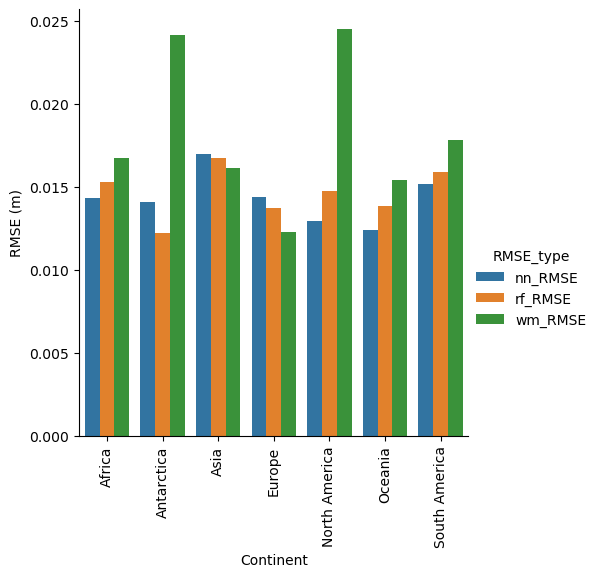

In [109]:
piv_df = error_by_cont.melt(id_vars=["Lat", "Lon","Hgt_m", "ZTD", "nn_model_prediction", "rf_Model_prediction", "WM_ZTD", "CONTINENT"], 
        var_name="RMSE_type", 
        value_name="RMSE").reset_index(drop=True)

import seaborn as sns
ax = sns.catplot(x = 'CONTINENT', y='RMSE', 
            hue = 'RMSE_type',data=piv_df[piv_df['RMSE_type'].isin(['nn_RMSE', 'rf_RMSE', 'wm_RMSE'])], 
            kind='bar').set(xlabel='Continent',ylabel='RMSE (m)')
ax.set_xticklabels(rotation=90) 
plt.show()

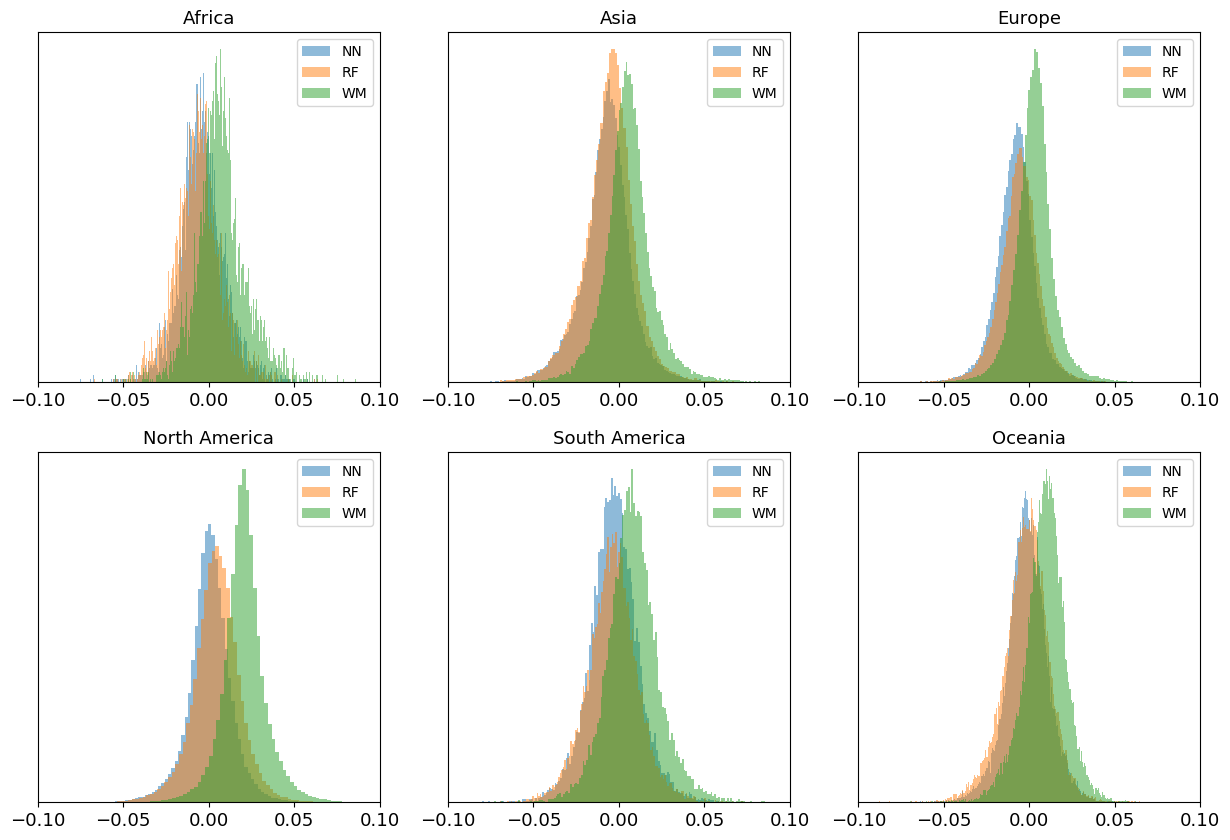

In [115]:
fig, axes=plt.subplots(2,3, figsize=(15,10))
label_size = 13
axes[0,0].set_title('Africa', fontsize=label_size)
axes[0,0].hist(new_test_continent[new_test_continent['CONTINENT']=='Africa'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Africa'].ZTD, bins=250, alpha=0.5, label='NN')
axes[0,0].hist(new_test_continent[new_test_continent['CONTINENT']=='Africa'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Africa'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[0,0].hist(new_test_continent[new_test_continent['CONTINENT']=='Africa'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='Africa'].ZTD, bins=250, alpha=0.5, label='WM')
axes[0,0].xaxis.set_tick_params(labelsize=label_size)
axes[0,0].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[0,0].set_yticks([])
axes[0,0].legend(loc='upper right')
# axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Antartica'].nn_model_prediction - 
#                new_test_continent[new_test_continent['CONTINENT']=='Antartica'].ZTD, bins=250)
# axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Antartica'].rf_Model_prediction - 
#                new_test_continent[new_test_continent['CONTINENT']=='Antartica'].ZTD, bins=250)
axes[0,1].set_title('Asia', fontsize=label_size)
axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Asia'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Asia'].ZTD, bins=250, alpha=0.5, label='NN')
axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Asia'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Asia'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Asia'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='Asia'].ZTD, bins=250, alpha=0.5, label='WM')
axes[0,1].xaxis.set_tick_params(labelsize=label_size)
axes[0,1].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[0,1].set_yticks([])
axes[0,1].legend(loc='upper right')
axes[0,2].set_title('Europe', fontsize=label_size)
axes[0,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Europe'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Europe'].ZTD, bins=250, alpha=0.5, label='NN')
axes[0,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Europe'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Europe'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[0,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Europe'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='Europe'].ZTD, bins=250, alpha=0.5, label='WM')
axes[0,2].xaxis.set_tick_params(labelsize=label_size)
axes[0,2].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[0,2].set_yticks([])
axes[0,2].legend(loc='upper right')
axes[1,0].set_title('North America', fontsize=label_size)
axes[1,0].hist(new_test_continent[new_test_continent['CONTINENT']=='North America'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='North America'].ZTD, bins=250, alpha=0.5, label='NN')
axes[1,0].hist(new_test_continent[new_test_continent['CONTINENT']=='North America'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='North America'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[1,0].hist(new_test_continent[new_test_continent['CONTINENT']=='North America'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='North America'].ZTD, bins=250, alpha=0.5, label='WM')
axes[1,0].xaxis.set_tick_params(labelsize=label_size)
axes[1,0].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[1,0].set_yticks([])
axes[1,0].legend(loc='upper right')
axes[1,1].set_title('South America', fontsize=label_size)
axes[1,1].hist(new_test_continent[new_test_continent['CONTINENT']=='South America'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='South America'].ZTD, bins=250, alpha=0.5, label='NN')
axes[1,1].hist(new_test_continent[new_test_continent['CONTINENT']=='South America'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='South America'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[1,1].hist(new_test_continent[new_test_continent['CONTINENT']=='South America'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='South America'].ZTD, bins=250, alpha=0.5, label='WM')
axes[1,1].xaxis.set_tick_params(labelsize=label_size)
axes[1,1].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[1,1].set_yticks([])
axes[1,1].legend(loc='upper right')
axes[1,2].set_title('Oceania', fontsize=label_size)
axes[1,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Oceania'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Oceania'].ZTD, bins=250, alpha=0.5, label='NN')
axes[1,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Oceania'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Oceania'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[1,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Oceania'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='Oceania'].ZTD, bins=250, alpha=0.5, label='WM')
axes[1,2].xaxis.set_tick_params(labelsize=label_size)
axes[1,2].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[1,2].set_yticks([])
axes[1,2].legend(loc='upper right')
plt.setp(axes, xlim=(-0.1, 0.1))
fig.savefig('Plots/Residual_by_continent.png', dpi=250)
plt.show()

# RAiDER bias testing on CONUS

In [87]:
utc_6 = pd.read_csv('../GNSS_US/US_UTC_6/GNSS/UNRcombinedGPS_ztd.csv')

In [116]:
import glob
import xarray as xr
import rasterio
weather_file_path = '../GNSS_US/US_UTC_6/weather_files/'
utc_6['WM_ZTD'] = 0
dates_ = np.unique(utc_6.Date.values)
for i, date in enumerate(dates_):
    print(date)
    df = utc_6[utc_6['Date']==date]
    loc = np.hstack((df.Lon.values.reshape(-1,1), df.Lat.values.reshape(-1,1), df.Hgt_m.values.reshape(-1,1)))
    with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T06_00_00*[A-Z].nc'.format(date=date.replace('-', '_'))))) as wm:
        hydro_total_1_interp = make_interpolator(wm, 'hydro_total')
        wet_total_1_interp = make_interpolator(wm, 'wet_total')
  
    hydro1 = hydro_total_1_interp(loc)
    wet1 = wet_total_1_interp(loc)
    td1 = hydro1 + wet1
    utc_6.loc[utc_6.groupby('Date').get_group(date).index,'WM_ZTD'] = td1
    

2017-01-01
2017-01-16
2017-01-31
2017-02-15
2017-03-02
2017-03-17
2017-04-01
2017-04-16
2017-05-01
2017-05-16
2017-05-31
2017-06-15
2017-06-30
2017-07-15
2017-07-30
2017-08-14
2017-08-29
2017-09-13
2017-09-28
2017-10-13
2017-10-28
2017-11-12
2017-11-27
2017-12-12
2017-12-27
2018-01-11
2018-01-26
2018-02-10
2018-02-25
2018-03-12
2018-03-27
2018-04-11
2018-04-26
2018-05-11
2018-05-26
2018-06-10
2018-06-25
2018-07-10
2018-07-25
2018-08-09
2018-08-24
2018-09-08
2018-09-23
2018-10-08
2018-10-23
2018-11-07
2018-11-22
2018-12-07
2018-12-22
2019-01-06
2019-01-21
2019-02-05
2019-02-20
2019-03-07
2019-03-22
2019-04-06
2019-04-21
2019-05-06
2019-05-21
2019-06-05
2019-06-20
2019-07-05
2019-07-20
2019-08-04
2019-08-19
2019-09-03
2019-09-18
2019-10-03
2019-10-18
2019-11-02
2019-11-17
2019-12-02
2019-12-17
2020-01-01
2020-01-16
2020-01-31
2020-02-15
2020-03-01
2020-03-16
2020-03-31
2020-04-15
2020-04-30
2020-05-15
2020-05-30
2020-06-14
2020-06-29
2020-07-14
2020-07-29
2020-08-13
2020-08-28
2020-09-12

In [99]:
utc_6

ID        Date     ZTD  wet_delay  hydrostatic_delay  times  sigZTD  \
0       14T1  2021-03-11  2.4168     0.1236             2.2932  21600  0.0017   
1       1LSU  2017-04-01  2.4121     0.1057             2.3064  21600  0.0025   
2       1LSU  2017-04-16  2.5237     0.2028             2.3209  21600  0.0027   
3       1LSU  2017-05-01  2.3576     0.0502             2.3074  21600  0.0026   
4       1LSU  2017-05-16  2.4437     0.1329             2.3108  21600  0.0025   
...      ...         ...     ...        ...                ...    ...     ...   
578672  ZUMB  2022-11-01  2.2915     0.0724             2.2191  21600  0.0018   
578673  ZUMB  2022-11-16  2.2932     0.0548             2.2384  21600  0.0018   
578674  ZUMB  2022-12-01  2.2729     0.0234             2.2495  21600  0.0016   
578675  ZUMB  2022-12-16  2.2258     0.0483             2.1775  21600  0.0015   
578676  ZUMB  2022-12-31  2.2567     0.0370             2.2197  21600  0.0017   

            Lat      Lon    Hgt_m    WM_ZTD  
0       45.4001 -75.9194   45.260  2.431951  
1       30.4074 -91.1803   -6.487  2.424443  
2       30.4074 -91.1803   -6.487  2.553064  
3       30.4074 -91.1803   -6.487  2.352915  
4       30.4074 -91.1803   -6.487  2.465099  
...         ...      ...      ...       ...  
578672  44.2907 -92.6813  295.980  2.314388  
578673  44.2907 -92.6813  295.980  2.311771  
578674  44.2907 -92.6813  295.980  2.289077  
578675  44.2907 -92.6813  295.980  2.248988  
578676  44.2907 -92.6813  295.980  2.279253  

[578677 rows x 11 columns]

In [153]:
from sklearn.metrics import mean_squared_error, r2_score
print("UTC_6 model")
predict = utc_6.WM_ZTD
true = utc_6.ZTD
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))

# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict-(2.5/100)))
print('RMSE: %.5f' % rmse)

errors = predict - true
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

UTC_6 model
Mean squared error: 0.0015943553
Mean: 0.02626
R2: 0.95902
RMSE: 0.03011
MAE: 0.02663


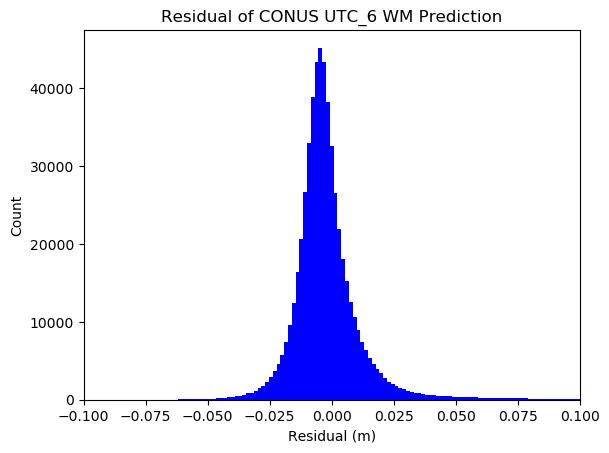

In [154]:
plt.hist(predict-(2.5/100)-true, bins=450, color='blue')
plt.title('Residual of CONUS UTC_6 WM Prediction')
plt.xlabel('Residual (m)')
plt.ylabel('Count')
plt.xlim(-0.1, 0.1)
# plt.text(-0.09, 400000, 'RMSE: {:.5f} m\n MAE: {:.5f} m \n MEAN: {:.5f} m'.format(0.00972, 0.00678, 0.00039 ), fontsize = 8, 
#          bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

In [106]:
error_by_station_ = utc_6.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'WM_ZTD']]

/tmp/ipykernel_18838/3230183749.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_station_ = utc_6.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'WM_ZTD']]


In [107]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [111]:
# error_by_station['nn_Avg_error'] = (test_US.nn_model_prediction-test_US.ZTD).groupby(test_US['ID']).mean()
# error_by_station['nn_RMSE'] = test_US.groupby('ID').apply(rmse)['rmse']
# error_by_station['rf_Avg_error'] = (test_US.rf_model_prediction-test_US.ZTD).groupby(test_US['ID']).mean()
# error_by_station['rf_RMSE'] = test_US.groupby('ID').apply(rmse_)['rmse']
error_by_station_['wm_Avg_error'] = (utc_6.WM_ZTD-utc_6.ZTD).groupby(utc_6['ID']).mean()
error_by_station_['wm_RMSE'] = utc_6.groupby('ID').apply(rmse__)['rmse']

In [109]:
error_by_station_

Lat       Lon     Hgt_m       ZTD    WM_ZTD  wm_Avg_error   wm_RMSE
ID                                                                           
14T1  45.4001  -75.9194    45.260  2.416800  2.431951      0.015151  0.015151
1LSU  30.4074  -91.1803    -6.487  2.503352  2.527270      0.023919  0.050552
1NSU  31.7508  -93.0976    28.071  2.478801  2.497865      0.019064  0.032627
1ULM  32.5290  -92.0759    16.000  2.477518  2.498503      0.020985  0.032689
59WE  33.4311 -112.1831   289.115  2.330079  2.352876      0.022797  0.024941
...       ...       ...       ...       ...       ...           ...       ...
ZOB1  41.2972  -82.2064   223.618  2.355874  2.393174      0.037299  0.056155
ZOLE  39.4217 -119.7534  1357.313  1.992253  2.049613      0.057361  0.068044
ZTL4  33.3797  -84.2967   261.134  2.393965  2.428607      0.034641  0.051123
ZUMA  37.5582 -117.4902  1924.552  1.845435  1.899402      0.053967  0.060225
ZUMB  44.2907  -92.6813   295.980  2.332103  2.354951      0.022848  0.024480

[5796 rows x 7 columns]

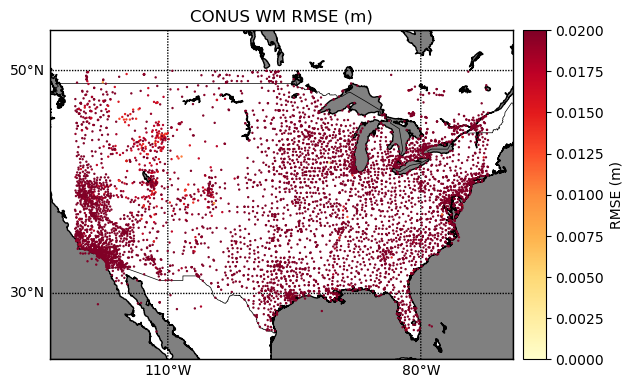

In [112]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = error_by_station_['Lat']
lon = error_by_station_['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,30)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=error_by_station_['wm_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
m.colorbar(label='RMSE (m)')
plt.title('CONUS WM RMSE (m)')
# plt.savefig('Plots/CONUS_RF_RMSE.png', dpi=250)
plt.show()

## Bias in general

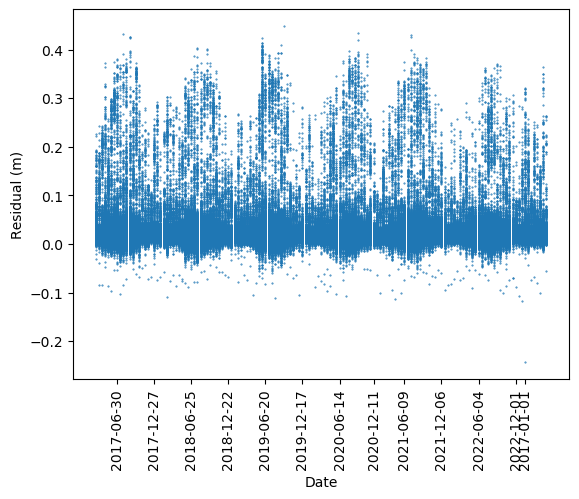

In [162]:
plt.scatter(utc_6.Date.values, (utc_6.WM_ZTD- utc_6.ZTD).values, s=0.2)
plt.xticks(np.unique(utc_6.Date)[::12], rotation=90)
plt.xlabel('Date')
plt.ylabel('Residual (m)')
# plt.title(station)
plt.show()

In [159]:
np.unique(utc_6.Date)[::12]

array(['2017-01-01', '2017-06-30', '2017-12-27', '2018-06-25',
       '2018-12-22', '2019-06-20', '2019-12-17', '2020-06-14',
       '2020-12-11', '2021-06-09', '2021-12-06', '2022-06-04',
       '2022-12-01'], dtype=object)

## Bias of one station

In [148]:
station = "ZOB1"
spec_df = utc_6[utc_6['ID']==station]

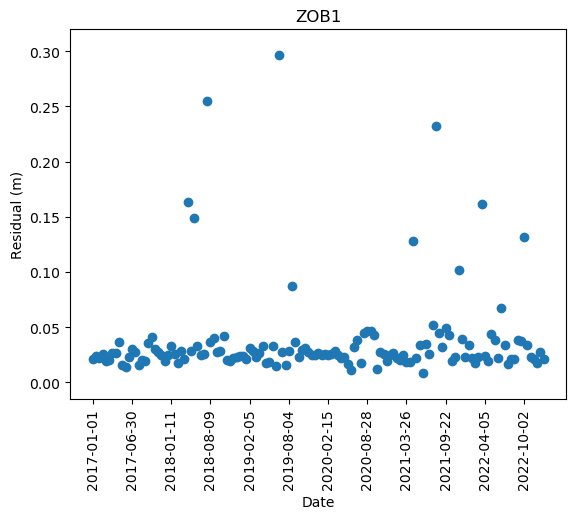

In [155]:
plt.scatter(spec_df.Date, spec_df.WM_ZTD- spec_df.ZTD)
plt.xticks(spec_df.Date[::12], rotation=90)
plt.xlabel('Date')
plt.ylabel('Residual (m)')
plt.title(station)
plt.show()

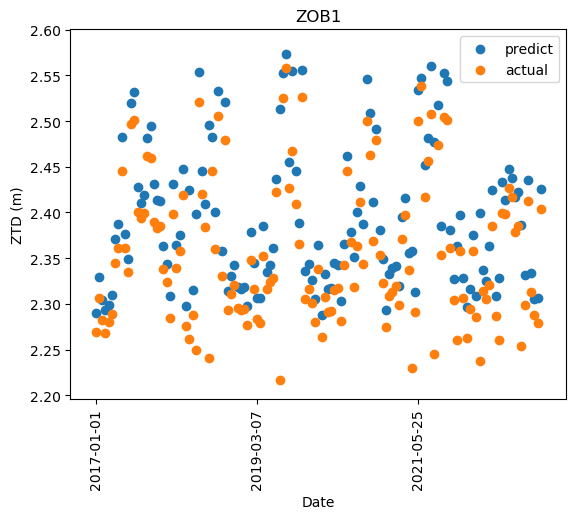

In [152]:
plt.scatter(spec_df.Date, spec_df.WM_ZTD, label='predict')
plt.scatter(spec_df.Date, spec_df.ZTD, label='actual')
plt.xticks(spec_df.Date[::50], rotation=90)
plt.xlabel('Date')
plt.ylabel('ZTD (m)')
plt.title(station)
plt.legend()
plt.show()